# <a name="top"></a>SWPLA PDDA 2020 Synthetic Sonic Log Generation Contest

**Author:** Ben Dowdell

**Date:** March XX, 2020

**Purpose:** To minimize RMSE in predicting Sonic logs (compressional & shear) from a suite of standard well logs

**Outline**

* [1. Initial Set-Up](#initial-setup)
** [1a. Standard Imports](#standard-imports)
** [1b. Sklearn Imports](#sklearn-imports)
** [1c. Helper Function Definitions](#helper-funcs)
* [2. Read Data](#read-data)
* [3. Inspect Data](#inspect-data)
* [4. EDA](#eda)
* [5. Imputing Missing Values](#imputing)
** [5a. PE estimation](#fe-pe)
** [5b. DTC approximation](#fe-dtc)
** [5c. DTS approximation](#fe-dts)

### Data Decription
#### Files
#### train.csv
All the values equals to -999 are marked as missing values.
- CAL - Caliper, unit in Inch,  
- CNC - Neutron, unit in dec 
- GR - Gamma Ray, unit in API
- HRD - Deep Resisitivity, unit in Ohm per meter,
- HRM - Medium Resistivity, unit in Ohm per meter,
- PE - Photo-electric Factor, unit in Barn,
- ZDEN - Density, unit in Gram per cubit meter, 
- DTC - Compressional Travel-time, unit in nanosecond per foot,
- DTS - Shear Travel-time, unit in nanosecond per foot,


#### test.csv
The test data has all features that you used in the train dataset, except the two sonic curves DTC and DTS.

####  sample_submission.csv
A valid sample submission.
<p><font style="">
</font></p>

## <a name="initial-setup"></a>1. Initial Set-Up

Back to [top](#top)

### <a name="standard-imports"></a> 1a. Standard Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal
from pprint import pprint
import pandas_profiling as pdp

random_state = 42
rng = np.random.RandomState(seed=42)

%matplotlib inline

### <a name="sklearn-imports"></a>1b. Sklearn Imports

In [2]:
# Preprocessing utilities
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split

# Hyperparameter Tuning
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

# Regression Models
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import BayesianRidge
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

# Dimensionality Reduction
from sklearn.decomposition import PCA

# Clustering Models
from sklearn.cluster import KMeans

# Evaluation Metrics
from sklearn.metrics import mean_squared_error, r2_score

# Visualization
from yellowbrick.model_selection import FeatureImportances

/home/bendowdell/anaconda3/envs/pdda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


### <a name="helper-funcs"></a>1c. Helper Function Definitions

Helper function to plot data histograms

In [3]:
def plot_data_distributions(df):
    """Plot histograms of each curve
    
    Paramters:
    df (pandas.DataFrame) : Input data frame containing log curves
    
    Returns:
    matplotlib.figure.Figure
    """
    fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(18,8))
    for ax, col in zip(axes.flatten(), df.columns.tolist()):
        ax.hist(df[col])
        if 'HR' in col:
            ax.set_xscale('log')
        ax.set_title('{} Histogram'.format(col))
    plt.tight_layout()
    return fig

Helper function plot data CDF's

In [4]:
def plot_data_cdf(df):
    """Plot cumulative distribution function of each curve
    
    Parameters:
    df (pandas.DataFrame) : Input data frame containing log curves
    
    Returns:
    matplotlib.figure.Figure
    """
    fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(18,8))
    for ax, col in zip(axes.flatten(), df.columns.tolist()):
        ax.hist(df[col], density=True, cumulative=-1)
        if 'HR' in col:
            ax.set_xscale('log')
        ax.set_title('{} Histogram'.format(col))
    plt.tight_layout()
    return fig

Helper function to plot well curves in a normal log display

In [5]:
def plot_well_curves(data):
    """
    Plots well log curves from an input data frame containing the data
    
    Parameters:
    data (pandas.DataFrame) : Input data frame containing the well log curves, one per column
    
    curve_names (list) : A list containing the column name of each well log curve in the input data frame
    
    Returns:
    matplotlib.figure.Figure
    """
    # get the column names as a list
    curve_names = data.columns.tolist()
    
    # create the figure
    fig, axes = plt.subplots(nrows=1, ncols=len(curve_names), sharey=True, figsize=(20,10))
    fig.suptitle('Training Well Data', fontsize=20)
    for ax, curve in zip(axes, curve_names):
        if curve in ['HRD', 'HRM']:
            ax.semilogx(data[curve], data.index, color='k')
        else:
            ax.plot(data[curve], data.index, color='k')
        if curve == 'CNC':
            ax.set_xlim(0.0, 1.0)
        if curve in ['DTC', 'DTS'] or 'DT' in curve:
            ax.set_title(curve, fontdict={'color':'r'})
            ax.invert_xaxis()
        else:
            ax.set_title(curve)
        ax.xaxis.tick_top()
        ax.invert_yaxis()
    fig.text(0.04, 0.5, 'Sample', va='center', rotation='vertical', fontdict={'fontsize':20})
    return fig

Helper function to remove outliers from log curves using standard deviation from median value in a window

In [6]:
def filter_curves(data, window, n_std):
    """
    Takes a data frame containing well log curves and filters outliers based on n-standard deviations
    from a median filtered version of the data.
    
    Parameters:
    data (pandas.DataFrame) : The input data frame containing data to be filtered.  Each column is a well log curve.
    
    window (int) : The size of the window to use in creating a median filtered curve (recommend 33)
    
    n_std (int) : The number of +/- standard deviations to use in considering outliers (recommend 2)
    
    Returns:
    df_clean (pandas.DataFrame) : The filtered well curves
    df_outliers (pandas.DataFrame) : The outlier data points removed by the filtering operation
    """
    # create a copy of the original data
    df_copy = data.copy()
    
    # create a data frame containing median-filtered version of the data
    df_medfilter = pd.DataFrame()
    for col in df_copy.columns.tolist():
        df_medfilter[col] = df_copy[col].rolling(window, min_periods=1, center=True).median()
        
    # create a data frame containing standard deviation of the data
    df_stddev = pd.DataFrame()
    for col in df_copy.columns.tolist():
        df_stddev[col] = df_medfilter[col].rolling(window, min_periods=1, center=True).std()
        
    # create a data frame containing the cleaned version of the data using standard deviation from the median filtered data
    # and create a data frame containing the removed outliers
    df_clean = pd.DataFrame()
    df_outliers = pd.DataFrame()
    for col in df_copy.columns.tolist():
        upper = df_medfilter[col] + df_stddev[col]*n_std
        lower = df_medfilter[col] - df_stddev[col]*n_std
        df_clean[col] = df_copy[col].where((df_copy[col] <= upper) & (df_copy[col] >= lower))
        #df_clean[col] = df_clean[col].interpolate(limit_area='inside')
        df_outliers[col] = df_copy[col].where(df_clean[col] != df_copy[col])
    
    return df_clean, df_outliers

Helper function to compare raw versus filtered logs

In [7]:
def qc_curve_filt(data_raw, data_cleaned, *args):
    """
    Plots well log curves from an input data frame containing the data
    
    Parameters:
    data_raw (pandas.DataFrame) : Input data frame containing the well log curves, one log per column
    
    data_cleaned (pandas.DataFrame) : Input data frame containing filtered log curves, one log per column
    
    *args (pandas.DataFrame) : Optional data frame containing outliers
    
    Returns:
    matplotlib.figure.Figure
    """
    
    # get the column names as a list, assumes col names are the same for each input data frame
    curve_names = data_raw.columns.tolist()
    
    # build the figure
    fig, axes = plt.subplots(nrows=1, ncols=len(curve_names), sharey=True, figsize=(20,10))
    fig.suptitle('Training Well Data', fontsize=20)
    for ax, curve in zip(axes, curve_names):
        if curve in ['HRD', 'HRM']:
            ax.semilogx(data_raw[curve], data_raw.index, color='k', lw=3)
            ax.semilogx(data_cleaned[curve], data_cleaned.index, color='r', lw=1)
            for arg in args:
                ax.semilogx(arg[curve], arg.index, lw=0, marker='.', mfc='y', mec='k', alpha=0.2)
        else:
            ax.plot(data_raw[curve], data_raw.index, color='k', lw=3)
            ax.plot(data_cleaned[curve], data_cleaned.index, color='r', lw=1)
            for arg in args:
                ax.plot(arg[curve], arg.index, lw=0, marker='.', mfc='y', mec='k', alpha=0.2)
        if curve == 'CNC':
            ax.set_xlim(0.0, 1.0)
        if curve in ['DTC', 'DTS']:
            ax.set_title(curve, fontdict={'color':'r'})
            ax.invert_xaxis()
        else:
            ax.set_title(curve)
        ax.xaxis.tick_top()
        ax.invert_yaxis()
    fig.text(0.04, 0.5, 'Sample', va='center', rotation='vertical', fontdict={'fontsize':20})
    return fig

Helper function to compare individual predictors to DTC & DTS

In [8]:
def compare_curves(predictor, dtc, dts):
    """
    Takes a predictor curve and plots it against both response variables, DTC & DTS
    
    Parameters:
    predictor (pandas.core.series.Series) : Independent Variable to compare, assumes either a column from a pandas DataFrame or ndarray-like
    
    dtc (pandas.core.series.Series) : DTC curve, assumes either a column from a pandas DataFrame or ndarray-like
    
    dts (pandas.core.series.Series) : DTS curve, assumes either a column from a pandas DataFrame or ndarray-like
    
    Returns:
    matplotlib.figure.Figure
    """
    fig = plt.figure(figsize=(20,10), linewidth=5, edgecolor='k')
    name = predictor.name
    fig.suptitle('{} curve comparison to DTC & DTS'.format(name), fontsize=20)
    
    ax1 = fig.add_subplot(2,2,1)
    if name == 'HRD':
        ax1.semilogy(predictor.index, predictor.values, 'k', lw=3)
    else:
        ax1.plot(predictor.index, predictor.values, 'k', lw=3)
    ax1c = ax1.twinx()
    ax1c.plot(dtc.index, dtc.values, 'r', lw=2)
    ax1c.invert_yaxis()
    ax1.set_ylabel(name)
    ax1c.set_ylabel('DTC', fontdict={'color':'r'})
    ax1.grid(False)
    ax1c.grid(False)
    
    ax2 = fig.add_subplot(2,2,2)
    ax2 = sns.scatterplot(x=predictor, y=dtc)
    if name == 'HRD':
        ax2.set_xscale('log')
    ax2.set_xlabel(name)
    ax2.set_ylabel('DTC')
    ax2.grid(False)
    
    ax3 = fig.add_subplot(2,2,3)
    if name == 'HRD':
        ax3.semilogy(predictor.index, predictor.values, 'k', lw=3)
    else:
        ax3.plot(predictor.index, predictor.values, 'k', lw=3)
    ax3c = ax3.twinx()
    ax3c.plot(dts.index, dts.values, 'r', lw=2)
    ax3c.invert_yaxis()
    ax3.set_ylabel(name)
    ax3c.set_ylabel('DTS', fontdict={'color':'r'})
    ax3.grid(False)
    ax3c.grid(False)
    
    ax4 = fig.add_subplot(2,2,4)
    ax4 = sns.scatterplot(x=predictor, y=dts)
    if name == 'HRD':
        ax4.set_xscale('log')
    ax4.set_xlabel(name)
    ax4.set_ylabel('DTS')
    ax4.grid(False)
    
    return fig

Helper function to calculate Root Mean Squared Error (RMSE), the primary evaluation metric for this project.

In [9]:
def evaluate_rmse(real, predicted):
    """Calculates the Root Mean Square Error
     
     Parameters:
     real (ndarray) : actual values as a numpy array
     predicted (ndarray) : predicted values as a numpy array
     
     Returns: RMSE Accuracy as a float
     
    """
    mse = np.square(np.subtract(real, predicted)).mean()
    return np.sqrt(mse)

Helper function to plot logs in a typical petrophysical layout

In [10]:
def petro_plot(gr, resd, neut, den, pe, dtc, dts):
    """
    Produces a typical petrophysical plot
    
    Parameters:
    gr (pandas.Series) : Gamma Ray curve as a pandas series
    resd (pandas.Series) : Deep Resistivity curve as a pandas series
    neut (pandas.Series) : Neutron Porosity curve as a pandas series
    den (pandas.Series) : Density curve as a pandas series
    pe (pandas.Series) : PE curve as a pandas series
    dtc (pandas.Series) : Compressional sonic curve as a pandas series
    dts (pandas.Series) : Shear sonic curve as a pandas series
    
    Returns : matplotlib.figure.Figure
    """
    
    fig = plt.figure(figsize=(20,12))

    # GR
    ax1 = fig.add_subplot(1,5,1)
    ax1.plot(gr, gr.index, 'k', lw=1)
    ax1.invert_yaxis()
    ax1.set_xlabel('GR')
    ax1.set_ylabel('Sample no.')
    ax1.xaxis.tick_top()
    ax1.set_xlim([0, 300])
    ax1.set_xticks([0, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300])
    ax1.xaxis.set_label_position('top')

    # RD
    ax2 = fig.add_subplot(1,5,2)
    ax2.semilogx(resd, resd.index, 'b', lw=1)
    ax2.set_xlabel('HRD')
    ax2.invert_yaxis()
    ax2.xaxis.tick_top()
    ax2.xaxis.set_label_position('top')

    # N-D
    ax3 = fig.add_subplot(1,5,3)
    ax3.plot(den, den.index, 'r', lw=1)
    ax3.xaxis.set_label_position('top')
    ax3.set_xlabel('ZDEN', labelpad=10, fontdict={'color':'r'})
    ax3.set_xlim(1.65, 2.65)
    ax3.invert_yaxis()
    ax3b = ax3.twiny()
    ax3b.plot(neut, neut.index, 'g', lw=1)
    ax3b.invert_xaxis()
    ax3b.set_xlabel('CNC', fontdict={'color':'g'})
    ax3b.set_xlim(0.6, 0.0)
    ax3b.xaxis.tick_top()
    ax3.xaxis.tick_top()
    ax3.set_xticks([1.65, 1.85, 2.05, 2.25, 2.45, 2.65])
    ax3.tick_params(axis='x', pad=35, top=True)
    ax3b.xaxis.set_label_position('top')
    ax3b.set_xticks([0.6, 0.48, 0.36, 0.24, 0.12, 0.0])

    # PE
    ax4 = fig.add_subplot(1,5,4)
    ax4.plot(pe, pe.index, 'k', lw=1)
    ax4.set_xlabel('PE')
    ax4.invert_yaxis()
    ax4.xaxis.tick_top()
    ax4.xaxis.set_label_position('top')

    # Sonic
    ax5 = fig.add_subplot(1,5,5)
    ax5.plot(dtc, dtc.index, 'b', lw=1)
    ax5.xaxis.set_label_position('top')
    ax5.set_xlabel('DTC', labelpad=10, fontdict={'color':'b'})
    ax5.set_xlim(50, 170)
    ax5.invert_xaxis()
    ax5.invert_yaxis()
    ax5b = ax5.twiny()
    ax5b.plot(dts, dts.index, 'r', lw=1)
    ax5b.invert_xaxis()
    ax5b.set_xlabel('DTS', fontdict={'color':'r'})
    ax5b.set_xlim(340, 100)
    ax5b.xaxis.tick_top()
    ax5.xaxis.tick_top()
    #ax5.set_xticks([170, 150, 130, 110, 90, 70, 50])
    ax5.set_xticks([230, 200, 170, 140, 110, 80, 50])
    ax5.tick_params(axis='x', pad=35, top=True)
    ax5b.xaxis.set_label_position('top')
    #ax5b.set_xticks([340, 300, 260, 220, 180, 140, 100])
    ax5b.set_xticks([460, 400, 340, 280, 220, 160, 100])

    plt.tight_layout()
    return fig

Helper function to plot RHOMAA-UMAA

In [11]:
def plot_rhomaa_umaa(pe, dens, phi):
    """Plot log data using RHOMAA-UMAA crossplot for mineralogy
    
    Parameters:
    pe (ndarray-like) : PE curve
    dens (ndarray-like) : Density curve
    phi (ndarray-like) : Neutron porosity curve
    color_var (optional) : Default 'None' will use index as color.  Option to pass in labels such as kmeans.labels_
    
    Returns:
    matplotlib.figure.Figure
    """
    # First, create the endmember points as a dataframe
    index = ['Quartz', 'Calcite', 'Dolomite', 'Anhydrite', 'K-Feldspar']
    data = {
        'rhoma' : [2.65, 2.71, 2.87, 2.95, 2.54],
        'uma' : [4.82, 13.79, 8.98, 14.99, 7.29],
    }
    df = pd.DataFrame(data=data, index=index)
    
    # Second, calculate umaa & rhomaa for the input logs
    u = pe * dens
    phid = (2.65 - dens)/(2.65-1.)
    phit = (phid + phi)/2
    #umaa = u / (1 - phit)
    #umaa = (u - phit*0.5)/(1-phit)/2
    rhomaa = (dens - phit*1.)/(1-phit) # assume brackish pore fluid rhof = 1.1 g/cc
    umaa = (pe * rhomaa) / 2
    
    # Finally, create and return figure
    fig = plt.figure(figsize=(28,10))
    
    gs = fig.add_gridspec(1, 6)
    
    ax1 = fig.add_subplot(gs[0,:-3])
    im = ax1.scatter(umaa, rhomaa, s=10, c=umaa.index, marker='.', cmap='inferno', alpha=0.8)
    ax1.scatter(df['uma'], df['rhoma'], c='r', marker='D')
    for i, txt in enumerate(df.index.tolist()):
        ax1.annotate(txt, (df['uma'].iloc[i]+0.03, df['rhoma'].iloc[i]-0.02), weight='bold')
    ax1.plot(df['uma'].loc[['Quartz','Calcite']], df['rhoma'].loc[['Quartz', 'Calcite']], 'k')
    ax1.plot(df['uma'].loc[['Quartz', 'Dolomite']], df['rhoma'].loc[['Quartz', 'Dolomite']], 'k')
    ax1.plot(df['uma'].loc[['Dolomite','Calcite']], df['rhoma'].loc[['Dolomite','Calcite']], 'k')
    ax1.set_xlabel('UMAA (barns/cc)')
    #ax1.set_xlim(2,16)
    ax1.set_ylabel('RHOMAA (g/cc)')
    #ax1.set_ylim(2.3, 3.1)
    ax1.invert_yaxis()
    ax1.set_title('RHOMAA-UMAA Crossplot', fontdict={'fontsize':20, 'fontweight':'bold'})
    cbar = fig.colorbar(im, ax=ax1)
    cbar.ax.invert_yaxis()
    cbar.set_label('sample no', fontdict={'fontweight':'bold'})
    
    ax4 = fig.add_subplot(gs[0,3])
    ax4.plot(phit, phit.index, 'k', lw=2, label='phit')
    ax4.plot(phi, phi.index, 'r', lw=0.5, label='phin')
    ax4.plot(phid, phid.index, 'g', lw=0.5, label='phid')
    ax4.invert_yaxis()
    ax4.set_ylabel('sample no')
    ax4.invert_xaxis()
    ax4.set_xlabel('Phi')
    ax4.xaxis.tick_top()
    ax4.xaxis.set_label_position('top')
    ax4.legend(loc='best')
    
    ax5 = fig.add_subplot(gs[0,4], yticklabels=())
    ax5.plot(umaa, umaa.index)
    ax5.invert_yaxis()
    ax5.set_xlabel('UMAA')
    ax5.xaxis.tick_top()
    ax5.xaxis.set_label_position('top')
    
    ax6 = fig.add_subplot(gs[0,5], yticklabels=())
    ax6.plot(rhomaa, rhomaa.index)
    ax6.invert_yaxis()
    ax6.set_xlabel('RHOMAA')
    ax6.xaxis.tick_top()
    ax6.xaxis.set_label_position('top')
    
    return fig, rhomaa, umaa
        
    

Helper function to plot Vp versus Vs using well known rock physics templates

In [12]:
def plot_vp_vs(x='DTC', y='DTS', df=None):
    """
    Plots measured Vp & Vs against well-known rock physics trends
    
    Parameters:
    x (pandas.Series) : Input DTC values, in us/ft
    y (pandas.Series) : Input DTS values, in us/ft
    df (pandas.DataFrame) : Input data frame containing x & y
    
    Returns:
    matplotlib.figure.Figure
    """
    
    vp_ft_s = 1e6 / df[x]
    vp_m_s = vp_ft_s /  3.281
    vp_km_s = vp_m_s / 1000
    
    vs_ft_s = 1e6 / df[y]
    vs_m_s = vs_ft_s / 3.281
    vs_km_s = vs_m_s / 1000
    
    xvp = np.arange(start=0, stop=8, step=0.1)
    
    Vs_castagna_ls = np.multiply(-0.05508, np.power(xvp, 2)) + np.multiply(1.0168, xvp) - 1.0305
    Vs_castagna_dm = np.multiply(0.5832, xvp) - 0.07776
    Vs_castagna_mudrock = np.multiply(0.8621, xvp) - 1.1724
    Vs_castagna_ss = np.multiply(0.8042, xvp) - 0.8559
    
    fig = plt.figure(figsize=(14,8))
    ax = fig.add_subplot(1,1,1)
    ax.plot(Vs_castagna_ls, xvp, '--b', lw=2, label='Castagna et al. (1993) Water-saturated Limestone')
    ax.plot(Vs_castagna_dm, xvp, '--c', lw=2, label='Castagna et al. (1993) Water-saturated Dolomite')
    ax.plot(Vs_castagna_mudrock, xvp, '--k', lw=2, label='Castagna et al. (1993) Mudrock line')
    ax.plot(Vs_castagna_ss, xvp, '--r', lw=2, label='Castagna et al. (1993) Water-saturated sandstone')
    im = ax.scatter(vs_km_s, vp_km_s, s=10, c=df.index, marker='.', cmap='inferno', alpha=0.8)
    ax.set_xlabel('Vs (km/s)')
    ax.set_ylabel('Vp (km/s)')
    ax.set_title('Vp vs. Vs', fontsize=20, fontweight='bold')
    ax.set_xlim([np.nanmin(vs_km_s), np.nanmax(vs_km_s)])
    ax.set_ylim([np.nanmin(vp_km_s), np.nanmax(vp_km_s)])
    ax.legend(loc='upper left')
    cbar = fig.colorbar(im, ax=ax)
    cbar.ax.invert_yaxis()
    cbar.set_label('sample no.', fontdict={'fontweight':'bold'})
    
    return fig

Helper function to plot Training Real vs. Training Predicted

In [13]:
def plot_real_vs_pred(y, y_pred, feat_name, split):
    """Function that plots y vs y_pred
    
    Parameters:
    y (ndarray like) : real values
    y_pred (ndarray like) : predicted values
    feat_name (str) : Feature name
    split (str) : Whether this is 'Train', 'Test', or 'Full Log'
    
    returns matplotlib.figure.Figure
    """
    fig = plt.figure(figsize=(20,6))
    fig.suptitle('Real {} vs. Predict'.format(split))
    
    ax1 = fig.add_subplot(1,2,1)
    ax1.plot(y.reset_index(drop=True, inplace=False), 'k', lw=2, label='y {}'.format(split))
    ax1.plot(y_pred, 'r', lw=1, label='y_{}_pred'.format(split))
    ax1.set_xlabel('sample no.')
    ax1.set_ylabel(feat_name)
    ax1.set_title('{} Real & Predict'.format(split))
    ax1.legend(loc='best')
    
    ax2 = fig.add_subplot(1,2,2)
    ax2.scatter(y, y_pred)
    ax2.set_xlabel('{} Real {}'.format(feat_name, split))
    ax2.set_ylabel('{} Predict {}'.format(feat_name, split))
    ax2.set_title('{} {} Predict vs. Real'.format(feat_name, split))
    
    return fig

Helper function to visually QC original vs. imputed data

In [14]:
def plot_original_vs_imputed(df_original, df_imputed):
    """Plots original and imputed log curves for visual QC
    
    Parameters:
    df_original (pandas.DataFrame) : Input data frame containing the well log curves, one log per column
    
    df_imputed (pandas.DataFrame) : Input data frame containing filtered log curves, one log per column
    
    Returns:
    matplotlib.figure.Figure
    """
    
    # get the column names as a list, assumes col names are the same for each input data frame
    curve_names = df_original.columns.tolist()
    
    # build the figure
    fig, axes = plt.subplots(nrows=1, ncols=len(curve_names), sharey=True, figsize=(20,10))
    fig.suptitle('Original vs Imputed Data', fontsize=20)
    for ax, curve in zip(axes, curve_names):
        if curve in ['HRD', 'HRM']:
            ax.semilogx(df_imputed[curve], df_imputed.index, color='r', lw=0.5, label='imputed')
            ax.semilogx(df_original[curve], df_original.index, color='k', lw=2, label='original')
        else:
            ax.plot(df_imputed[curve], df_imputed.index, color='r', lw=0.5, label='imputed')
            ax.plot(df_original[curve], df_original.index, color='k', lw=2, label='original')
        if curve == 'CNC':
            ax.set_xlim(0.0, 1.0)
        if curve in ['DTC', 'DTS']:
            ax.set_title(curve, fontdict={'color':'r'})
            ax.invert_xaxis()
        else:
            ax.set_title(curve)
        ax.xaxis.tick_top()
        ax.invert_yaxis()
        ax.legend(loc='upper left')
    fig.text(0.04, 0.5, 'Sample', va='center', rotation='vertical', fontdict={'fontsize':20})
    return fig

Helper function to find consecutive NaN values and the starting index number
[Consecutive NaN larger than threshold](https://stackoverflow.com/questions46007776/consecutive-nan-larger-than-threshold-in-pandas-dataframe)

In [15]:
def consecutive_nans(index, col, threshold):
    """Function returns the starting index of consecutive NaN's in an input column
    Uses Divakar's answer in above link
    """
    
    thresh = threshold
    
    a = index.values
    b = col.values
    
    idx0 = np.flatnonzero(np.r_[True, np.diff(np.isnan(b))!=0, True])
    count = np.diff(idx0)
    idx = idx0[:-1]
    valid_mask = (count>=thresh) & np.isnan(b[idx])
    out_idx = idx[valid_mask]
    out_num = a[out_idx]
    out_count = count[valid_mask]
    out = range(int(out_num),int(out_num)+int(out_count)-1)
    
    return out

## 2. <a name="read-data"></a>Read in Data

Back to [top](#top)

In [16]:
df_w1 = pd.read_csv('../data/train.csv')

In [17]:
df_w1.head()

,CAL,CNC,GR,HRD,HRM,PE,ZDEN,DTC,DTS
0,-999.0,-999.0,41.4699,-999.0,-999.0,-999.0,-999.0,128.0737,319.0654
1,-999.0,-999.0,42.5053,-999.0,-999.0,-999.0,-999.0,127.8347,318.7825
2,-999.0,-999.0,43.1548,-999.0,-999.0,-999.0,-999.0,127.2307,317.3323
3,-999.0,-999.0,43.2410,-999.0,-999.0,-999.0,-999.0,126.2917,313.6486
4,-999.0,-999.0,40.3218,-999.0,-999.0,-999.0,-999.0,125.3985,307.8903


## 3. <a name="inspect-data"></a>Inspect Data

Back to [top](#top)

In [18]:
df_w1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30143 entries, 0 to 30142
Data columns (total 9 columns):
CAL     30143 non-null float64
CNC     30143 non-null float64
GR      30143 non-null float64
HRD     30143 non-null float64
HRM     30143 non-null float64
PE      30143 non-null float64
ZDEN    30143 non-null float64
DTC     30143 non-null float64
DTS     30143 non-null float64
dtypes: float64(9)
memory usage: 2.1 MB


All data are type float64

In [19]:
df_w1.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
CAL,30143.0,-8.394576,129.970219,-999.0,8.05835,8.6250,9.04885,21.0642
CNC,30143.0,-23.692615,157.142679,-999.0,0.12280,0.1936,0.33715,3490.1582
GR,30143.0,38.959845,108.504554,-999.0,17.24875,36.8218,58.34615,1470.2534
HRD,30143.0,3.977690,365.112753,-999.0,0.71770,1.6230,3.15830,10000.0000
HRM,30143.0,1.547299,456.908969,-999.0,0.71205,1.6281,3.28060,60467.7617
PE,30143.0,-17.446739,149.083136,-999.0,0.05310,4.9415,7.85665,28.1064
ZDEN,30143.0,-20.229982,148.809506,-999.0,2.22670,2.4322,2.55135,3.2597
DTC,30143.0,-54.891703,372.858812,-999.0,66.30435,78.3551,107.02250,155.9803
DTS,30143.0,-9.737567,440.314119,-999.0,118.53435,137.6893,182.97315,487.4384


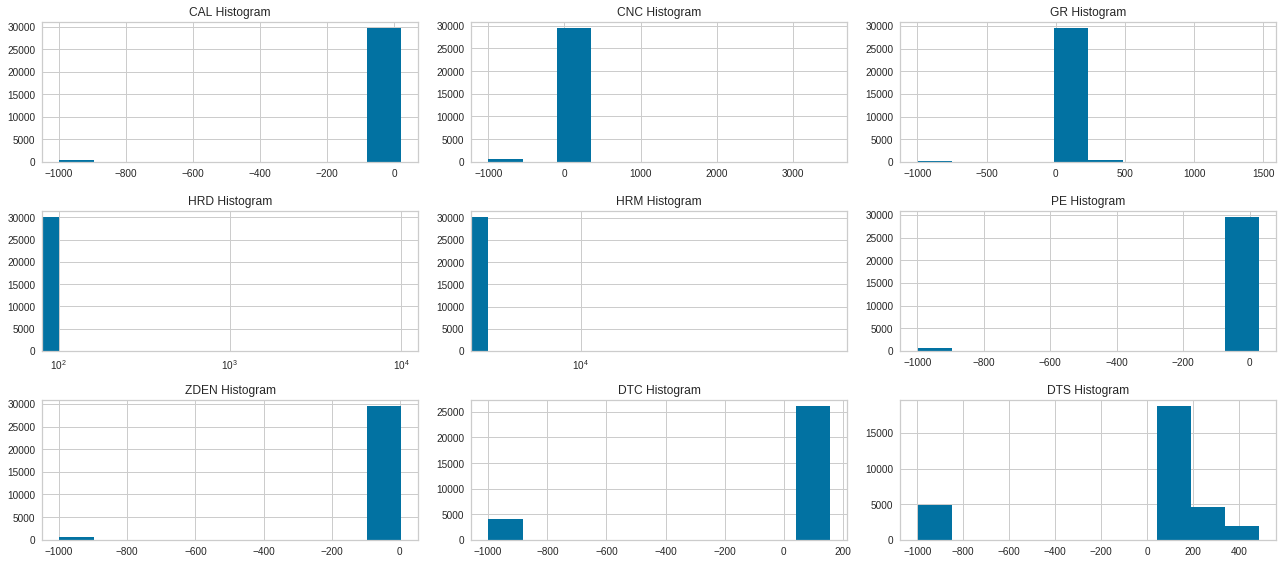

In [20]:
plot_data_distributions(df_w1.dropna())
plt.show()

Samples with value of -999.0 need to be replaced with NaN

In [21]:
df_w1.replace(to_replace=-999.0, value=np.nan, inplace=True)

In [22]:
df_w1.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
CAL,29633.0,8.654281,1.749145,5.9304,8.135600,8.62500,9.063000,21.0642
CNC,29408.0,0.683437,30.689679,-0.1028,0.127100,0.19850,0.343100,3490.1582
GR,29889.0,47.780541,51.377519,-0.1460,18.026100,37.08220,58.532800,1470.2534
HRD,29758.0,16.953912,349.067878,0.0541,0.740450,1.66275,3.180350,10000.0000
HRM,29758.0,14.492077,445.361622,0.0616,0.734700,1.66515,3.308900,60467.7617
PE,29464.0,5.173227,4.781088,-0.0232,0.054200,5.04250,7.949700,28.1064
ZDEN,29462.0,2.393818,0.196276,-1.9238,2.234800,2.43960,2.553000,3.2597
DTC,26089.0,91.814381,24.337910,49.9705,71.357000,85.23760,112.112600,155.9803
DTS,25278.0,180.655730,81.141960,80.5804,129.446625,144.59305,191.475125,487.4384


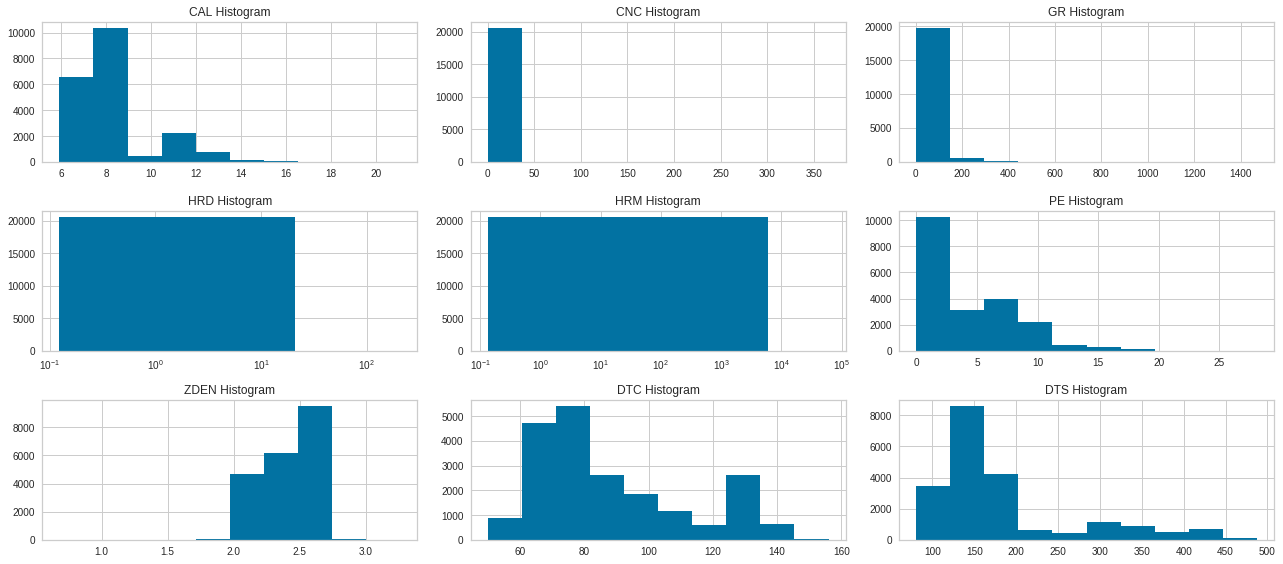

In [23]:
plot_data_distributions(df_w1.dropna())
plt.show()

There are some suspicious values here that we will explore in the next step.

1. CNC should range from 0.0 to 1.0
1. GR should not have values less than 0.0
1. PE should not have values less than 0.0
1. ZDEN should not have values less than 0.0

## <a name="eda"></a>4. Exploratory Data Analysis (EDA) & Cleaning

Back to [top](#top)

Before making any edits to values, plot the data for visual QC inspection

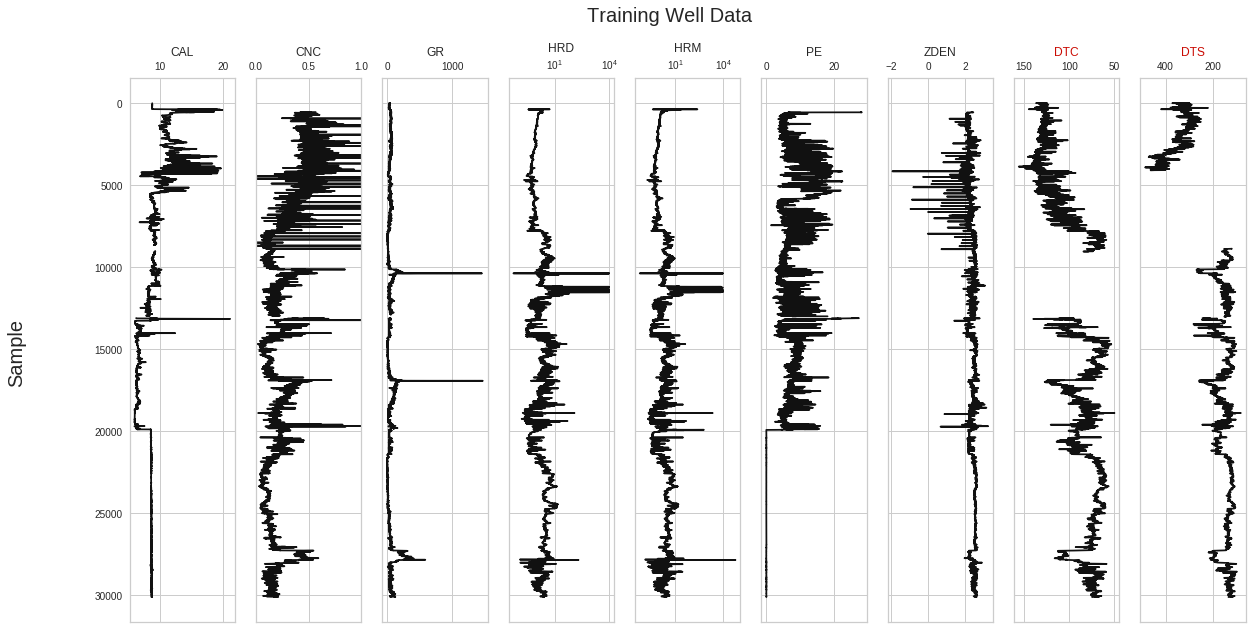

In [24]:
well_plot_fig = plot_well_curves(df_w1)
plt.show()

Let's try a [RHOMAA-UMAA crossplot](http://www.kgs.ku.edu/Publications/Bulletins/LA/11_crossplot.html) to see if we can differentiate lithologies.

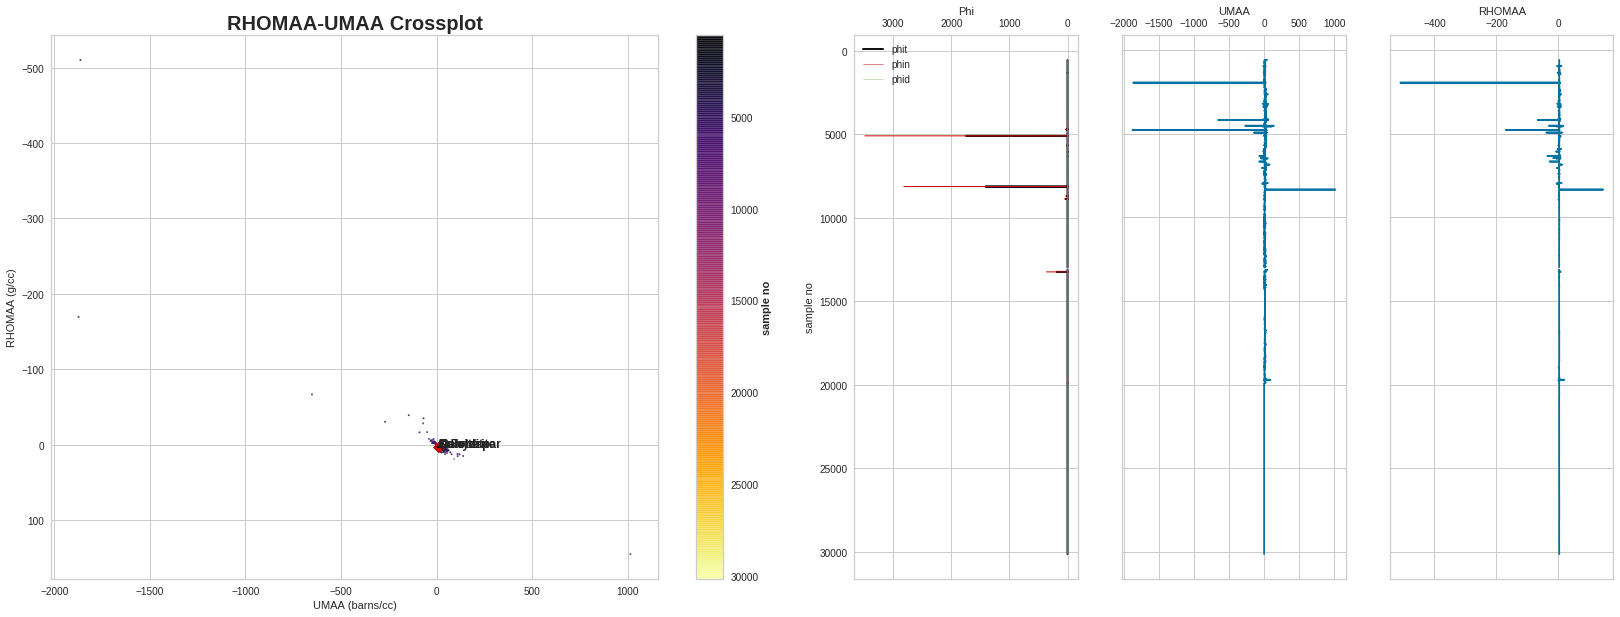

In [25]:
plot_rhomaa_umaa(df_w1['PE'], df_w1['ZDEN'], df_w1['CNC'])
plt.show()

Definitely outliers are present!

In [26]:
df_w1.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
CAL,29633.0,8.654281,1.749145,5.9304,8.135600,8.62500,9.063000,21.0642
CNC,29408.0,0.683437,30.689679,-0.1028,0.127100,0.19850,0.343100,3490.1582
GR,29889.0,47.780541,51.377519,-0.1460,18.026100,37.08220,58.532800,1470.2534
HRD,29758.0,16.953912,349.067878,0.0541,0.740450,1.66275,3.180350,10000.0000
HRM,29758.0,14.492077,445.361622,0.0616,0.734700,1.66515,3.308900,60467.7617
PE,29464.0,5.173227,4.781088,-0.0232,0.054200,5.04250,7.949700,28.1064
ZDEN,29462.0,2.393818,0.196276,-1.9238,2.234800,2.43960,2.553000,3.2597
DTC,26089.0,91.814381,24.337910,49.9705,71.357000,85.23760,112.112600,155.9803
DTS,25278.0,180.655730,81.141960,80.5804,129.446625,144.59305,191.475125,487.4384


Limit CNC to range between 0.0 and 1.0

In [27]:
df_w1.loc[df_w1['CNC'] < 0.0, ['CNC']] = np.nan
df_w1.loc[df_w1['CNC'] > 1.0, ['CNC']] = np.nan

Limit GR to range between 0.0 and 300.0

In [28]:
df_w1.loc[df_w1['GR'] < 0.0, ['GR']] = np.nan
df_w1.loc[df_w1['GR'] > 300.0, ['GR']] = np.nan

Limit PE to have values no less than 0.0

In [29]:
df_w1.loc[df_w1['PE'] < 0.0, ['PE']] = np.nan

Limit ZDEN to have values no less than 0.0

In [30]:
df_w1.loc[df_w1['ZDEN'] < 0.0, ['ZDEN']] = np.nan

In [31]:
df_w1.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
CAL,29633.0,8.654281,1.749145,5.9304,8.135600,8.62500,9.063000,21.0642
CNC,29308.0,0.247144,0.155301,0.0041,0.126800,0.19800,0.340900,0.9997
GR,29685.0,45.468596,40.347602,0.0000,17.867400,36.87760,58.015600,299.9370
HRD,29758.0,16.953912,349.067878,0.0541,0.740450,1.66275,3.180350,10000.0000
HRM,29758.0,14.492077,445.361622,0.0616,0.734700,1.66515,3.308900,60467.7617
PE,29455.0,5.174812,4.780959,0.0000,0.054200,5.04380,7.950150,28.1064
ZDEN,29454.0,2.394661,0.189292,0.0035,2.234900,2.43970,2.553100,3.2597
DTC,26089.0,91.814381,24.337910,49.9705,71.357000,85.23760,112.112600,155.9803
DTS,25278.0,180.655730,81.141960,80.5804,129.446625,144.59305,191.475125,487.4384


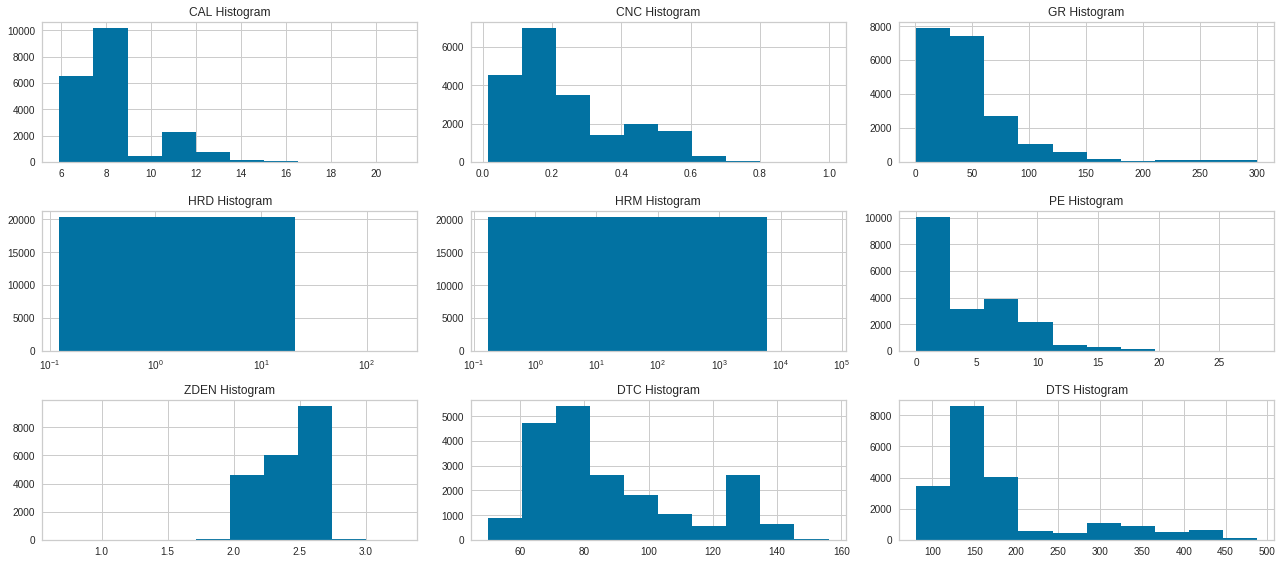

In [32]:
plot_data_distributions(df_w1.dropna())
plt.show()

These value ranges are substantially more acceptable.  Re-plot the data and visually inspect

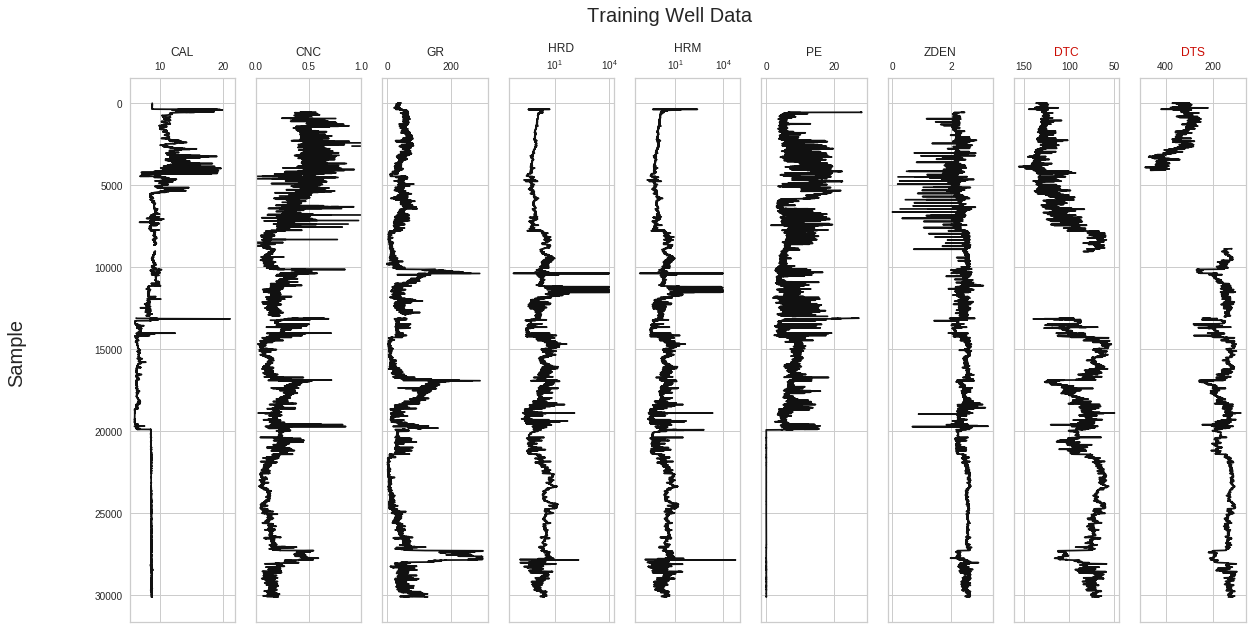

In [33]:
well_plot_fig = plot_well_curves(df_w1)
plt.show()

Overall, this appears to be better.  The PE final 10,000 values look suspect, though.

**Let's attempt filtering out the spikes remaining in the data.**

The filter first calculates an n-moving window median filtered version of the data and then eliminates values that fall outside of +/- n-standard deviations.

It might make sense to first standardize the data using RobustScaler (uses interquartile range 25-75% of the data) and pass the standardized data to the filter.

After filter, the data can be transformed back to its non-standardized domain.

In [34]:
rs = RobustScaler()
scaled_features = rs.fit_transform(df_w1.values)
scaled_features_df = pd.DataFrame(data=scaled_features, index=df_w1.index, columns=df_w1.columns)

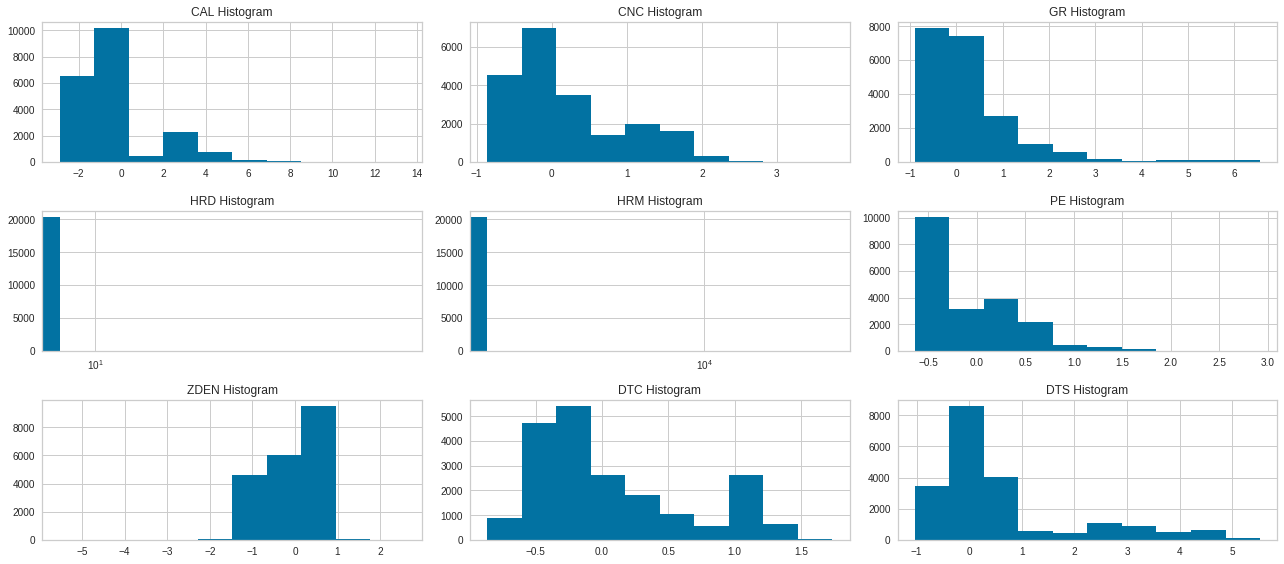

In [35]:
plot_data_distributions(scaled_features_df.dropna())
plt.show()

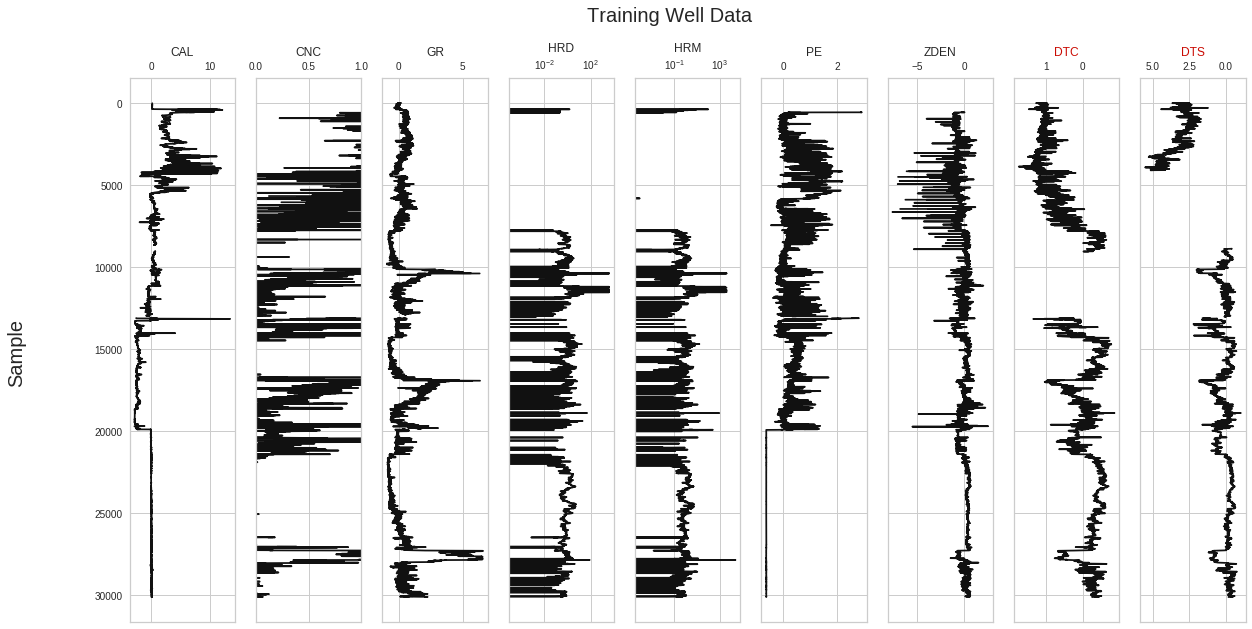

In [36]:
plot_well_curves(scaled_features_df)
plt.show()

Pass the scaled data to the filter and then backtransform the filtered data

In [37]:
df_clean_scaled, df_outliers_scaled = filter_curves(scaled_features_df, 81, 2)

# Backtransform the cleaned data & outliers to the unscaled domain
clean_unscaled = rs.inverse_transform(df_clean_scaled.values)
df_clean = pd.DataFrame(data=clean_unscaled, columns=df_w1.columns)
outliers_unscaled = rs.inverse_transform(df_outliers_scaled.values)
df_outliers = pd.DataFrame(data=outliers_unscaled, columns=df_w1.columns)

In [38]:
df_w1.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
CAL,29633.0,8.654281,1.749145,5.9304,8.135600,8.62500,9.063000,21.0642
CNC,29308.0,0.247144,0.155301,0.0041,0.126800,0.19800,0.340900,0.9997
GR,29685.0,45.468596,40.347602,0.0000,17.867400,36.87760,58.015600,299.9370
HRD,29758.0,16.953912,349.067878,0.0541,0.740450,1.66275,3.180350,10000.0000
HRM,29758.0,14.492077,445.361622,0.0616,0.734700,1.66515,3.308900,60467.7617
PE,29455.0,5.174812,4.780959,0.0000,0.054200,5.04380,7.950150,28.1064
ZDEN,29454.0,2.394661,0.189292,0.0035,2.234900,2.43970,2.553100,3.2597
DTC,26089.0,91.814381,24.337910,49.9705,71.357000,85.23760,112.112600,155.9803
DTS,25278.0,180.655730,81.141960,80.5804,129.446625,144.59305,191.475125,487.4384


In [39]:
df_clean.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
CAL,21632.0,8.652002,1.603670,5.9778,8.219875,8.62500,9.068925,19.5202
CNC,15114.0,0.218983,0.132769,0.0315,0.121000,0.18250,0.278775,0.6868
GR,15743.0,46.845773,42.946324,0.0000,19.049000,36.98350,57.620400,299.9302
HRD,19642.0,2.887718,8.575268,0.1295,0.700500,1.62545,3.121525,231.2297
HRM,18284.0,2.913507,9.047824,0.1853,0.690050,1.53440,3.170175,244.4038
PE,11931.0,5.875870,4.673858,0.0265,0.065600,5.74090,8.175450,26.3707
ZDEN,14373.0,2.406506,0.168309,1.9769,2.243200,2.45380,2.559200,2.8262
DTC,14958.0,89.541953,23.340215,55.4076,70.700875,81.68805,106.334050,141.0543
DTS,15411.0,179.289173,79.461633,96.9005,129.486900,145.15630,189.802350,455.3579


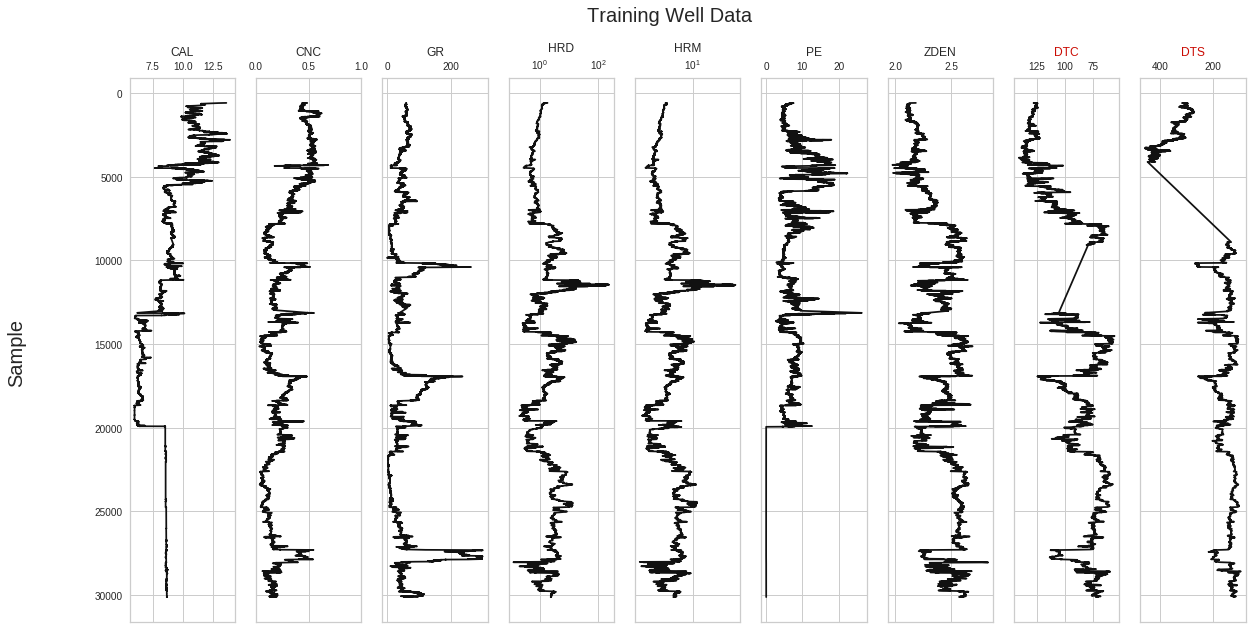

In [40]:
#cleaned_fig = plot_well_curves(df_clean)
cleaned_fig = plot_well_curves(df_clean.interpolate(limit_area='inside').dropna(axis=0, inplace=False))
plt.show()

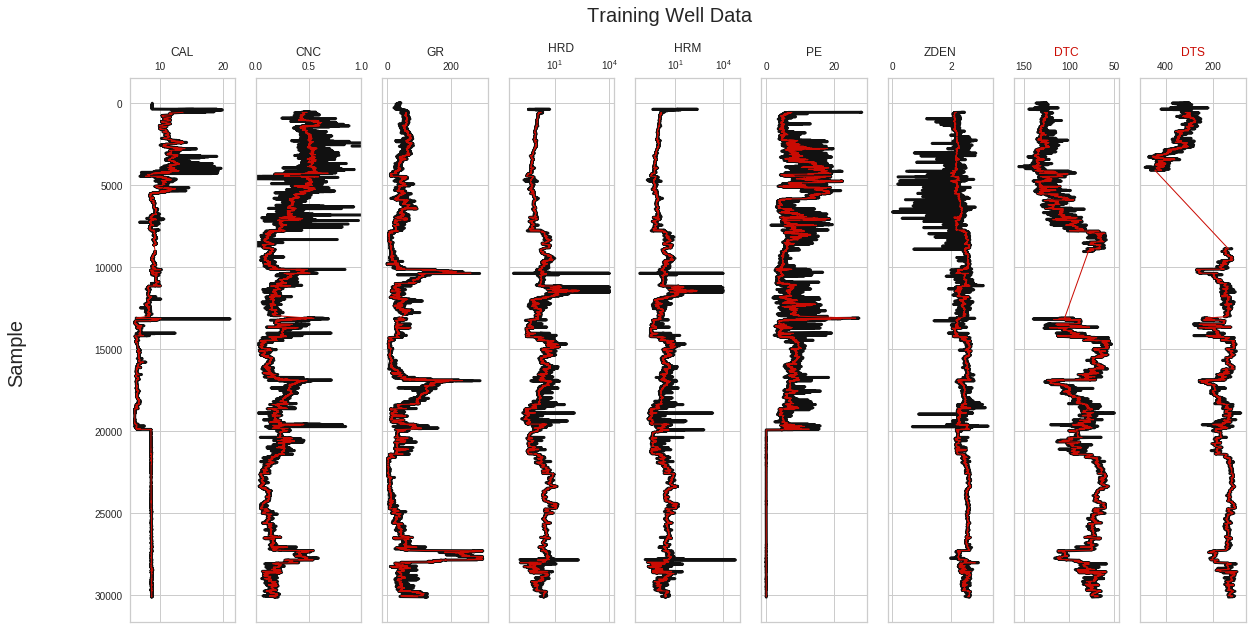

In [41]:
#qc_fig = qc_curve_filt(df_w1, df_clean)
qc_fig = qc_curve_filt(df_w1, df_clean.interpolate(limit_area='inside').dropna(axis=0, inplace=False))
#qc_fig = qc_curve_filt(df_w1, df_clean, df_outliers)
plt.show()

**At this point, it seems prudent to make some plots comparing our final cleaned curves to established rock property trends as a QC of the imputation and filtering**

Use plot_vp_vs to plot the imputed data against well known lithology trends, first the *pre-imputation* data ...

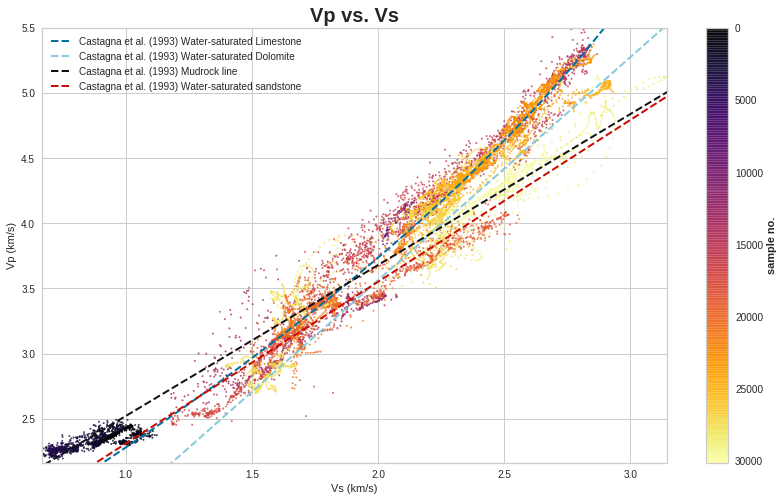

In [42]:
plot_vp_vs(x='DTC', y='DTS', df=df_clean)
plt.show()

**A few observations:**

1. Limestone appears to be a significant lithology.

1. Shale / Claystone also appear to be present throughout the well.

1. Sands are present.  Some sands may be difficult to discriminate in the overlap zone between Shale, Sand, & Limestone lines.  Gas-charged sands fall below the water-saturated sandstone line.

1. There may be a minor amount of dolomite present in the system.

1. Vp & Vs trends are obviously dependent upon lithology.  Plotting all of the data together, there is obvious heteroscedasticity.  Linear models would not fare well directly predicting Vs from Vp.  However, by using other features which are sensitive to lithologic variations, we should be able to build a robust model to handle these challenges.

QC lithologies with RHOMAA-UMAA crossplot

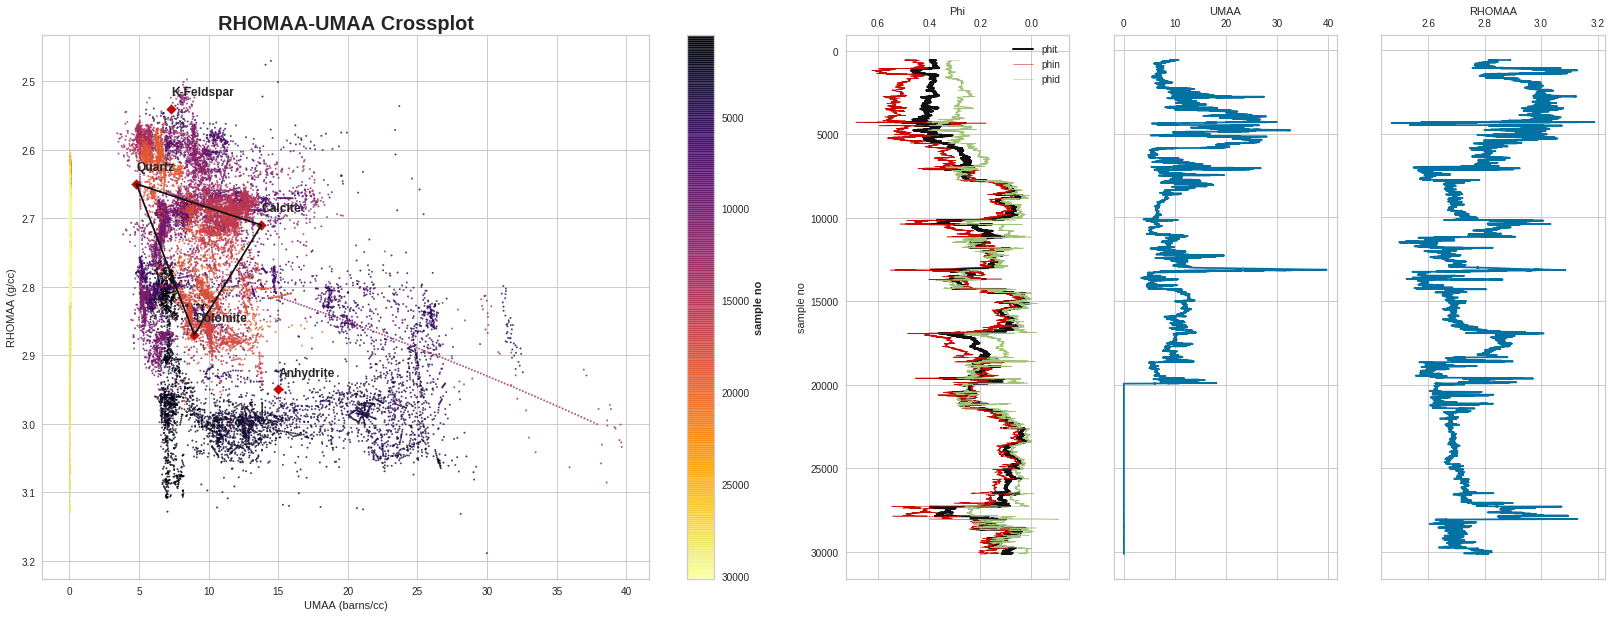

In [43]:
fig,_,_ = plot_rhomaa_umaa(df_clean['PE'].interpolate(limit_area='inside'), df_clean['ZDEN'].interpolate(limit_area='inside'), df_clean['CNC'].interpolate(limit_area='inside'))
plt.show()

The filtering operation has done a good job of removing outliers while keeping the overall signal intact

PE definitely has some bad values, as evident both on the log plot and the RHOMAA-UMAA transform crossplot.

**CAL seems a little suspect, though.  It seems unusual for CAL to increase at the bottom of the hole**

In fact, CAL and PE basically go bad at the same sample number, so it is likely they had a shared tool failure

There are several ways to proceed.

A few observations:

* CAL could be useful (variations in the wellbore are related to geomechanical properties), but it can also be rather stationary.
* If we want to maximize the amount of data available for estimating DTC & DTS, then interpolation is necessary.
* The last 10,000 samples in the PE curve appear to be bogus.  Maybe these can be estimated using the shallower section?
* HRM (Medium Resisitivity) should be dropped.  Without knowing the depth of investigation, it is likely to be contaminated with well-bore fluids.  HRD (Deep Resisitivity) is the better resistivity curve to use.  Maybe we could calculate Rt?

In [44]:
plt.rcParams["axes.labelsize"] = 20

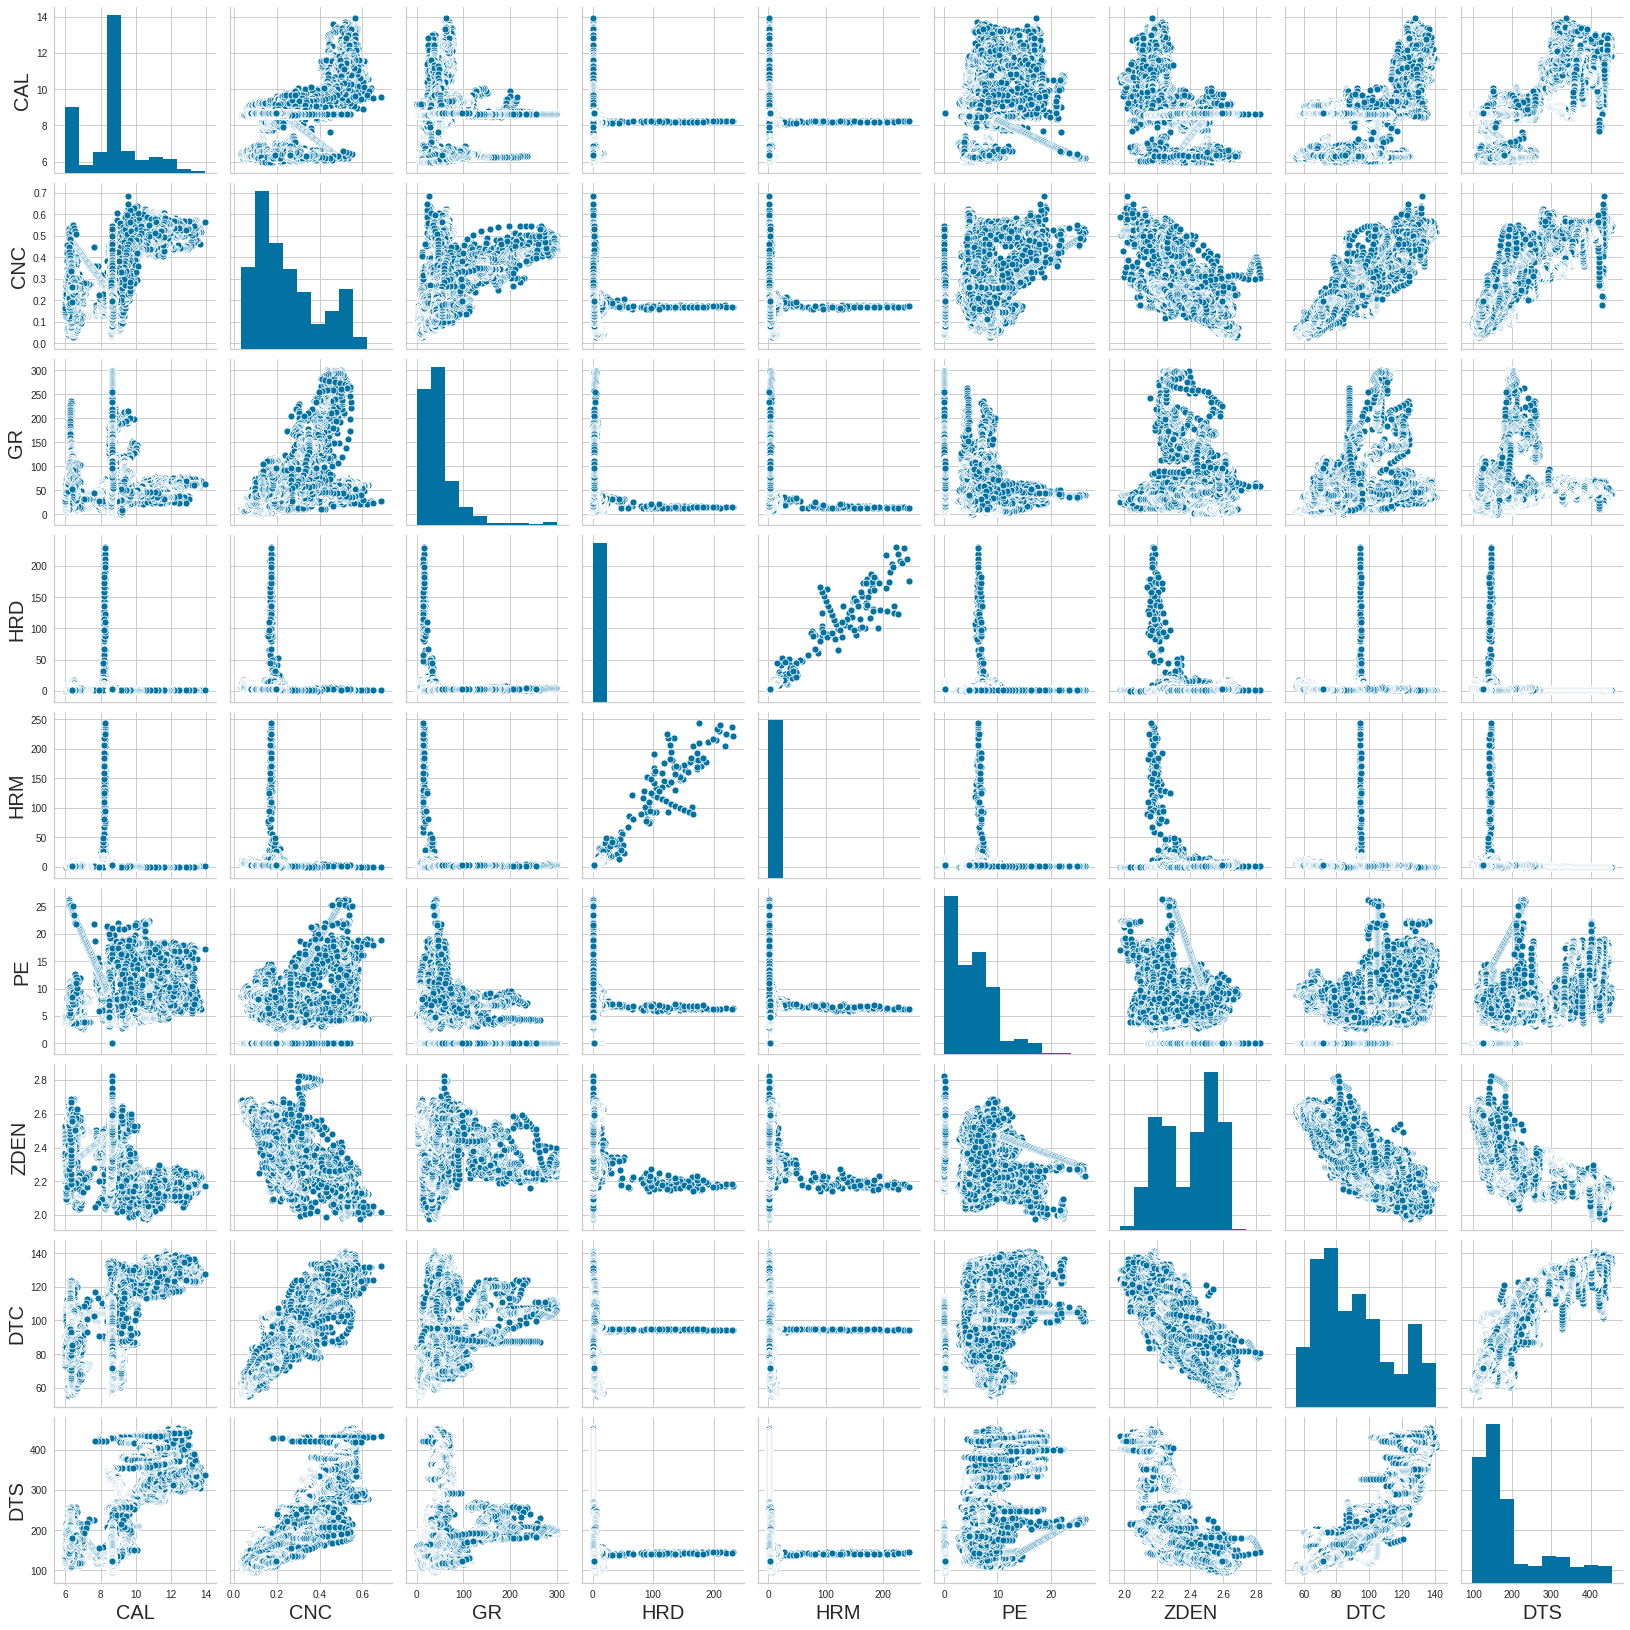

In [45]:
sns.pairplot(df_clean.interpolate(limit_area='inside').dropna(axis=0, inplace=False))
plt.show()

Several predictors exhibit a degree of multicollinearity

* CNC & GR, which also exhibits heteroscedasticity
* CNC & ZDEN
* HRM & HRD

Feature ranking will be an important step

PCA may also be useful

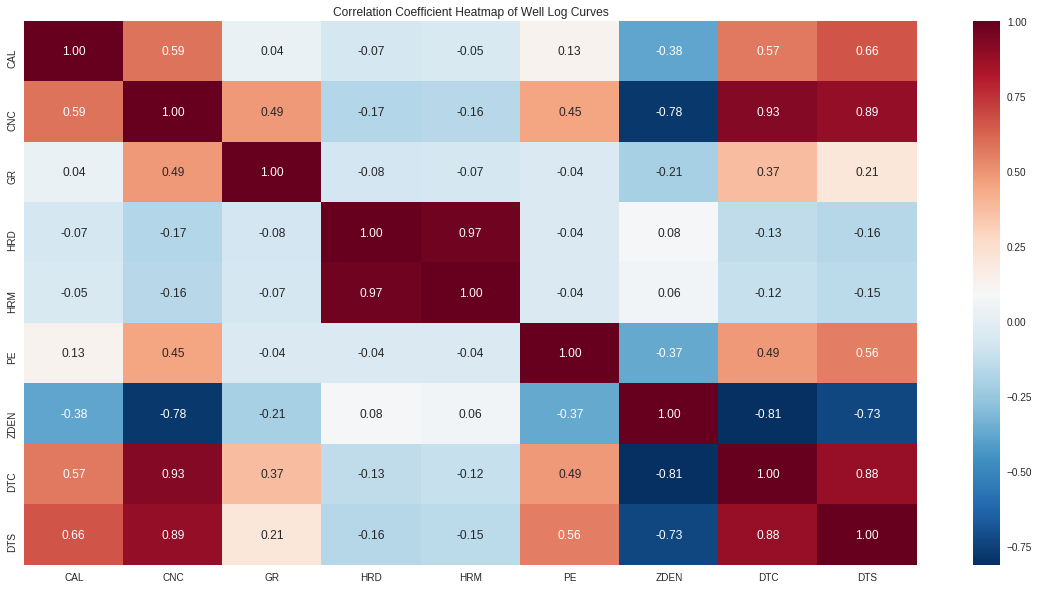

In [46]:
fig = plt.figure(figsize=(20,10))
ax = sns.heatmap(df_clean.interpolate(limit_area='inside').dropna(axis=0, inplace=False).corr(), cmap="RdBu_r", annot=True, fmt=".2f")
ax.set_title('Correlation Coefficient Heatmap of Well Log Curves')
plt.show()

Observations:

* CAL has reasonably high positive correlation to both DTC & DTS, as well as CNC.
* CNC has reasonably high positive correlation to CAL, GR, PE, as well as to DTC & DTS
* GR has moderate positive correlation to DTC & DTS
* HRD & HRM do not exhibit strong correlation with any other parameters than themselves, *but this could be due to the fact they are log-scale*
* PE has moderately positive correlation with CNC, DTC, & DTS
* ZDEN has a high negative correlation with CNC, DTC, & DTS, and mild negative correlation with CAL, GR, & PE

The recommendation going forward will be to drop CAL & HRM from the set of inputs.

**Create df_subset:**

1. Drop 'CAL' & 'HRM'

1. Find NaN index values for DTC & DTS

1. Interpolate to fill all gaps, then remove interpolated values for DTC & DTS

1. Remove bad PE values and replace with NaN

In [47]:
df_subset = df_clean.copy().drop(labels=['CAL','HRM'], axis=1)

In [48]:
dtc_nans = consecutive_nans(df_subset.index, df_subset['DTC'], threshold=100)
dts_nans = consecutive_nans(df_subset.index, df_subset['DTS'], threshold=100)

In [49]:
dtc_nans

range(9071, 13126)

In [50]:
dts_nans

range(4104, 8901)

Visually QC dtc_nans & dts)nans

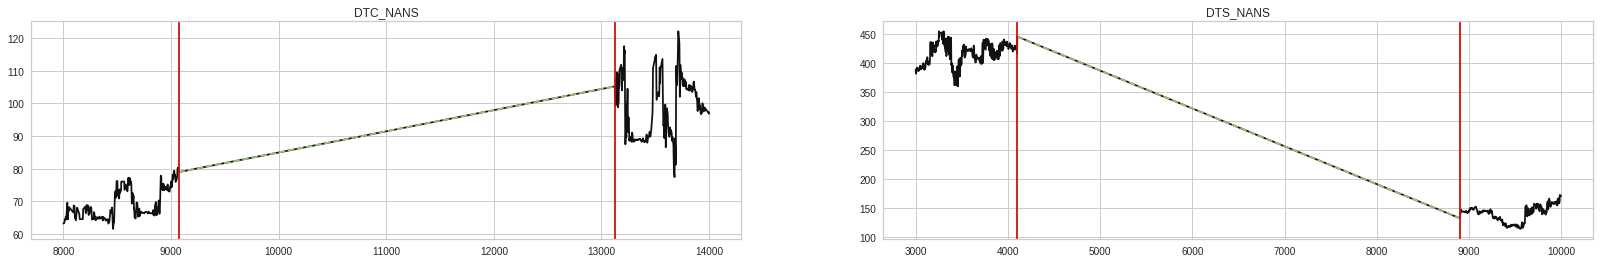

In [51]:
fig = plt.figure(figsize=(28,4))

ax1 = fig.add_subplot(121)
ax1.plot(df_subset['DTC'].interpolate(limit_area='inside').iloc[8000:14000], 'k')
ax1.plot(df_subset.interpolate(limit_area='inside').dropna(axis=0)['DTC'].loc[dtc_nans], '--g')
ax1.axvline(dtc_nans[0], ymin=0, ymax=140, c='r')
ax1.axvline(dtc_nans[-1], ymin=0, ymax=140, c='r')
ax1.set_title('DTC_NANS')

ax2 = fig.add_subplot(122)
ax2.plot(df_subset['DTS'].interpolate(limit_area='inside').iloc[3000:10000], 'k')
ax2.plot(df_subset.interpolate(limit_area='inside').dropna(axis=0).loc[dts_nans,'DTS'], '--g')
ax2.axvline(dts_nans[0], ymin=0, ymax=500, c='r')
ax2.axvline(dts_nans[-1], ymin=0, ymax=500, c='r')
ax2.set_title('DTS_NANS')

plt.show()

In [52]:
df_subset = df_subset.interpolate(limit_area='inside')
df_subset = df_subset.dropna()
df_subset.loc[dtc_nans,'DTC'] = np.nan # use loc since we have dropped rows and iloc no longer equals loc
df_subset.loc[dts_nans,'DTS'] = np.nan

In [53]:
df_subset[df_subset['PE'] < 1].head(1)

,CNC,GR,HRD,PE,ZDEN,DTC,DTS
19939,0.2689,41.2673,1.1991,0.049,2.1834,91.1456,185.8183


In [54]:
df_subset.loc[19939:,'PE'] = np.nan
pe_nans = consecutive_nans(df_subset.index, df_subset['PE'], threshold=1000)

In [55]:
df_subset.reset_index(drop=True, inplace=True)

In [56]:
df_subset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
CNC,29550.0,0.245812,0.148303,0.0315,0.129800,0.198488,0.333054,0.6868
GR,29550.0,46.867002,44.807744,0.0000,16.588850,37.496694,57.555233,299.9302
HRD,29550.0,2.861479,8.280165,0.1295,0.722125,1.584667,3.108196,231.2297
PE,19361.0,7.680453,3.478978,2.6803,5.031600,6.991150,8.848800,26.3707
ZDEN,29550.0,2.393974,0.166965,1.9769,2.236662,2.438875,2.549461,2.8262
DTC,25495.0,91.055340,23.799113,55.4076,71.485124,83.461300,109.622800,141.0543
DTS,24753.0,177.410474,78.520700,96.9005,130.399914,143.039473,189.284956,455.3579


In [57]:
df_subset.head()

,CNC,GR,HRD,PE,ZDEN,DTC,DTS
0,0.4633,60.081839,1.8688,6.6753,2.1849,126.5374,305.9166
1,0.4821,60.043330,1.7827,6.6690,2.1394,127.0895,309.3540
2,0.4821,60.004822,1.7049,6.5535,2.1370,127.4648,312.7448
3,0.4689,59.966313,1.6703,6.6136,2.1395,127.6743,315.0485
4,0.4865,59.927804,1.6453,6.6984,2.1377,127.7576,316.3320


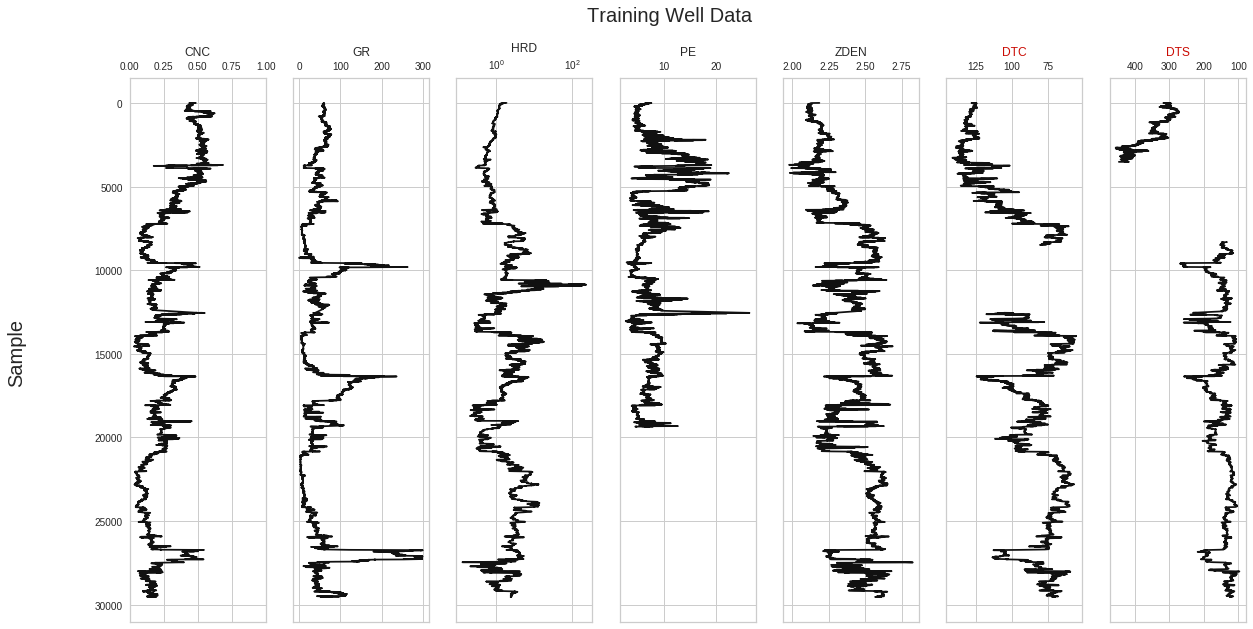

In [58]:
plot_well_curves(df_subset)
plt.show()

Re-set nan indexes for DTC, DTS, & PE now that the index values have been reset

In [59]:
dtc_nans = consecutive_nans(df_subset.index, df_subset['DTC'], threshold=100)
dts_nans = consecutive_nans(df_subset.index, df_subset['DTS'], threshold=100)
pe_nans = consecutive_nans(df_subset.index, df_subset['PE'], threshold=1000)

## 5. <a name="imputing"></a> Imputing missing values

Back to [top](#top)



First, let's replace all bad values in PE starting at index 19939 to the end with NaN's

In [ ]:
df_subset['PE'].iloc[19939:] = np.nan

In [ ]:
plot_well_curves(df_subset)
plt.show()

Ok, looks good.

**So.**

We will use a function *consecutive_nans* to find the gaps we want to fill with imputed values.  *consecutive_nans* searches for consecutive NaN values in a column above a specified threshold and returns a range that starts at the beginning of the consecutive NaNs and ends at the last NaN.

Once these values are spliced in, interpolate to fill any remaining *small* gaps in each column.

In [ ]:
df_subset_imputed = df_subset.copy()

dtc_nans = consecutive_nans(df_subset.index, df_subset['DTC'], threshold=100)
df_subset_imputed['DTC'].iloc[dtc_nans] = df_subset_imp_br['DTC'].iloc[dtc_nans].rolling(window=27, center=True).max().rolling(window=101, center=True).median()

dts_nans = consecutive_nans(df_subset.index, df_subset['DTS'], threshold=100)
df_subset_imputed['DTS'].iloc[dts_nans] = df_subset_imp_br['DTS'].iloc[dts_nans].rolling(window=27, center=True).max().rolling(window=101, center=True).median()

pe_nans = consecutive_nans(df_subset.index, df_subset['PE'], threshold=1000)
df_subset_imputed['PE'].iloc[pe_nans] = df_subset_imp_br['PE'].iloc[pe_nans].rolling(window=27, center=True).max().rolling(window=101, center=True).median()

df_subset_imputed = df_subset_imputed.interpolate(limit_area='inside')

In [ ]:
plot_well_curves(df_subset_imputed)
plt.show()

In [ ]:
qc_curve_filt(df_subset.interpolate(limit_area='inside'), df_subset_imputed)
plt.show()

The imputed values for DTC & DTS look plausible.

The imputed values for PE seem off trend and too high.

In [ ]:
petro_plot(df_subset_imputed['GR'], df_subset_imputed['HRD'], df_subset_imputed['CNC'], df_subset_imputed['ZDEN'], df_subset_imputed['PE'], df_subset_imputed['DTC'], df_subset_imputed['DTS'])
plt.show()

**We now have a continuous data set for each curve.**

Visually, the curves are appealing and look like data that we might receive from a petrophysicist upon completion of log edit & QC.

**A few thoughts and observations:**

  1. The imputed values are noticeably smoother than the real values.  Will this affect model performance?
  
  1. DTS imputed values are not as stable as DTC.
  
  1. Overall, the data does not look overly-processed.  Hopefully enough variation is preserved at this point by using n-standard deviation from the median filters to build a robust model.
    
  1. The estimated section of PE seems too high in value?  Are these estimated values reliable?  Maybe a different method needs to be used for PE.
    
  1. Aside from PE, these curves are ready for model fitting.  If the model does not perform well, we can:
    
      a. Splice the filtered imputed sections back into the previous iteration of filtered curves and use these for model building,
      
      b. Use interpolated trend for DTC & DTS instead of imputed values, or
       
      c. Abandon the data-driven solution for imputing & estimating missing values for traditional physics-based rock property model approaches.
      
**Let's continue by comparing where we started the imputation process to where we finished:**

1. Raw curves with minimal edits for obviously bad values *vs.* Median-Filtered Curves

1. Median-Filtered Curves *vs.* Real data with imputed data spliced in + Additional Median-Filtering

1. Real data with imputed data spliced in *vs.* Real data with imputed data spliced in + Additional Median-Filtering

In [ ]:
qc_curve_filt(df_w1.drop(labels=['CAL','HRM'], axis=1, inplace=False), df_subset)
qc_curve_filt(df_subset, df_subset_imputed)
qc_curve_filt(df_w1.drop(labels=['CAL','HRM'], axis=1, inplace=False), df_subset_imputed)
plt.show()

In [ ]:
plot_rhomaa_umaa(df_subset_imputed['PE'], df_subset_imputed['ZDEN'], df_subset_imputed['CNC'])
plt.show()

The imputed PE values are very obvious here.  The RHOMAA-UMAA plot suggests this section is calcitic, but plots outside of the calcite endmember.  I'm not very trusting of these values at this point ...

In [ ]:
plot_data_distributions(df_subset_imputed.dropna())
plt.show()

**Compare each feature to the response variables, DTC & DTS**

In [ ]:
all_features = df_subset_imputed.columns.tolist()
predictors = [x for x in all_features if x not in ['DTC', 'DTS']]

In [ ]:
for col in predictors:
    ax = compare_curves(df_subset_imputed[col], df_subset_imputed['DTC'], df_subset_imputed['DTS'])
plt.show()

**Gameplan:**

1. Estimate missing PE for samples beyond 20000 and splice in
1. Estimate missing DTC & DTS using either Faust or Gardner and splice in
1. Build a data-driven model for estimating DTC & DTS

## <a name="fe"></a> 6. Feature Engineering

Back to [top](#top)

Before proceeding to estimating DTC & DTS, if we want to use as much of the data as possible, we need to attempt to estimate the bad values for PE as well as missing DTC & DTS.

1. [6a. PE Curve Estimation](#fe-pe)
1. [6b. DTC Approximation](#fe-dtc)
1. [6c. DTS Approximation](#fe-dts)

### <a name="fe-pe"></a> 6a. Feature Engineering - PE Curve Estimation

Back to [top](#top)

The goal is to estimate PE for the final 10,000 samples that appear to have a bad measurement.

If we can robustly estimate the PE curve that appears to be usable, then we can splice in the estimated section for the bad data samples, keeping the good data.

We previously observed that CNC & ZDEN were most correlated to PE, so take a closer look.

In [ ]:
sns.pairplot(df_subset_interp[['CNC','PE','ZDEN']])

It is also worth crossplotting PE and HRD using a semilog scale to see if there is any relation not immediately noticeable in linear scale

In [ ]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(1,1,1)
ax = sns.scatterplot(x='HRD', y='PE', data=df_subset_interp)
ax.set_xscale('log')
plt.show()

We need to identify at which sample the values become constantly bad.  Maybe one way to do this is to look at the gradient

In [ ]:
df_subset_interp[df_subset_interp['PE'] < 2]

A quick df filter operation suggests that the bad PE values start at index 19338.

In [ ]:
fig = plt.figure(figsize=(20,10))

ax1 = fig.add_subplot(2,2,1)
ax1.plot(df_subset_interp['PE'].index, np.gradient(df_subset_interp['PE']))
ax1.scatter(19338, df_subset_interp['PE'].iloc[19338], c='k', s=100)
ax1.set_xlabel('sample no.')
ax1.set_ylabel('Gradient of PE')
ax1.set_title('Gradient of PE vs. Sample No.')

ax2 = fig.add_subplot(2,2,2)
ax2.plot(range(19200, 20000), np.gradient(df_subset_interp['PE'])[19200:20000])
ax2.scatter(19338, df_subset_interp['PE'].iloc[19338], c='k', s=100)
ax2.set_xlabel('sample no.')
ax2.set_ylabel('Gradient of PE')
ax2.set_title('Zoomed plot about PE Gradient Samples')

ax3 = fig.add_subplot(2,2,3)
ax3.plot(np.gradient(np.gradient(df_subset_interp['PE'])))
ax3.set_xlabel('sample no.')
ax3.set_ylabel('Second derivative of PE')
ax3.set_title('Second derivative of PE')

ax4 = fig.add_subplot(2,2,4)
ax4.plot(range(19200, 20000), np.gradient(np.gradient(df_subset_interp['PE']))[19200:20000], 'k', label='Second derivative')
ax4.plot(range(19200, 20000), np.gradient(df_subset_interp['PE'])[19200:20000], 'r', label='First derivative')
ax4.scatter(19338, df_subset_interp['PE'].iloc[19338], s=100)
ax4.set_xlabel('Sample no.')
ax4.set_ylabel('Second Derivative of PE')
ax4.set_title('Second Derivative of PE')

plt.legend(loc='best')
plt.tight_layout()
plt.show()

Visual inspection of the first and second derivative confirm that index 19338 is the start of the offending data.

Index Number 19338 is the point at which PE values appear to go consistently bad.  We can use all data up to this point for attempting to estimate PE.

In [ ]:
df_pe = df_subset_interp[['CNC','HRD','ZDEN','PE']].iloc[0:19338].copy()

Take the log of 'HRD' to put it in the same scale as CNC, ZDEN, & PE

In [ ]:
df_pe['HRD'] = df_pe['HRD'].apply(np.log)

In [ ]:
df_pe.rename(columns={'HRD':'log_HRD'}, inplace=True)

In [ ]:
df_pe.head()

In [ ]:
df_pe.info()

In [ ]:
df_pe.describe().transpose()

In [ ]:
#np.log(df_pe['HRD']).plot()
df_pe['log_HRD'].plot()
df_pe['PE'].plot()

In [ ]:
sns.pairplot(df_pe)

1. Train-Test-Split
1. Randomized Parameter Search + Cross Validation (Hyperparameter Tuning)
1. Grid-Search + K-Fold Cross Validation (Hyperparameter Fine Tuning)
1. Model Evaluation
1. QC real vs. predicted PE
1. Splice predicted data in for bad data, keeping good data

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df_pe[['CNC', 'log_HRD', 'ZDEN']], df_pe['PE'], test_size=0.3, random_state=random_state)

Instantiate a default Random Forest Regressor

In [ ]:
rf = RandomForestRegressor(random_state=random_state)

In [ ]:
print('Parameters currently in use:\n')
pprint(rf.get_params())

Define a random grid for RandomizedSearchCV to select initial hyperparameter values

In [ ]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start=100, stop=1000, num=10)]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(start=10, stop=100, num=10)]

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Method of selecting samples for training each tree
bootstrap = [True, False]

In [ ]:
random_grid = {'n_estimators': n_estimators,
              'max_features': max_features,
              'max_depth': max_depth,
              'min_samples_split': min_samples_split,
              'min_samples_leaf': min_samples_leaf,
              }

In [ ]:
pprint(random_grid)

Train the random search

In [ ]:
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid, n_iter=100, cv=5, verbose = 2, random_state=random_state, n_jobs=-1)

In [ ]:
rf_random.fit(X_train, y_train)

In [ ]:
rf_random.best_params_

Training Root Mean Squared Error for RandomForestRegressor with RandomizedSearchCV

In [ ]:
y_train_pred = rf_random.best_estimator_.predict(X_train)
print('Training RMSE: {}'.format(mean_squared_error(y_train, y_train_pred, squared=False)))
print('R2 Score: {}'.format(r2_score(y_train, y_train_pred)))

Testing Root Mean Squared Error for RandomForestRegressor with RandomizedSearchCV

In [ ]:
y_test_pred = rf_random.best_estimator_.predict(X_test)
print('Testing RMSE: {}'.format(mean_squared_error(y_test, y_test_pred, squared=False)))
print('R2 Score: {}'.format(r2_score(y_test, y_test_pred)))

Compare to a non-tuned default RandomForestRegressor

In [ ]:
rf_default = RandomForestRegressor(random_state=random_state)

In [ ]:
rf_default.fit(X_train, y_train)

Default RFR Training Root Mean Squared Error

In [ ]:
y_train_default_pred = rf_default.predict(X_train)
print('Default RF Training RMSE: {}'.format(mean_squared_error(y_train, y_train_default_pred, squared=False)))
print('Default RF R2 Score :{}'.format(r2_score(y_train, y_train_default_pred)))

Default RFR Testing Root Mean Squared Error

In [ ]:
y_test_default_pred = rf_default.predict(X_test)
print('Default RF Testing RMSE: {}'.format(mean_squared_error(y_test, y_test_default_pred, squared=False)))
print('Default RF R2 Score: {}'.format(r2_score(y_test, y_test_default_pred)))

Initial hyperparameter tuning using RandomizedSearchCV has improved the scores, but let's now use GridSearchCV to attempt to tune for a little more performance

In [ ]:
param_grid = {
    'bootstrap': [True],
    'max_depth': [40, 45, 50, 55, 60],
    'max_features': ['sqrt'],
    'min_samples_split': [2],
    'min_samples_leaf': [1],
    'n_estimators': [int(x) for x in np.linspace(start=700, stop=900, num=21)],
}

In [ ]:
pprint(param_grid)

In [ ]:
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

In [ ]:
grid_search.fit(X_train, y_train)

In [ ]:
grid_search.best_params_

GridSearchCV Train RMSE

In [ ]:
y_train_gs_pred = grid_search.best_estimator_.predict(X_train)
print('RF GridSearch Best Estimator RMSE: {}'.format(mean_squared_error(y_train, y_train_gs_pred, squared=False)))
print('RF GridSearch Best Estimator R2: {}'.format(r2_score(y_train, y_train_gs_pred)))

GridSearchCV Test RMSE

In [ ]:
y_test_gs_pred = grid_search.best_estimator_.predict(X_test)
print('RF GridSearch Best Estimator Test RMSE: {}'.format(mean_squared_error(y_test, y_test_gs_pred, squared=False)))
print('RF GridSearch Best Estimator Test R2: {}'.format(r2_score(y_test, y_test_gs_pred)))

The best estimator from gridsearch performed slightly worse on the training data but slightly better on the testing data.

In [ ]:
grid_search.best_estimator_.feature_importances_

Instantiate a new RandomForestRegressor using the parameters of the GridSearchCV best estimator

In [ ]:
rf_best = grid_search.best_estimator_

In [ ]:
rf_best.get_params

Use Yellowbrick to evaluate model performance further

In [ ]:
viz = FeatureImportances(rf_best)
viz.fit(X_train, y_train)
viz.show()

Plot Training vs. Predict & Test vs. Predict

In [ ]:
plot_real_vs_pred(y_train, y_train_gs_pred, feat_name='PE', split='Train')
plt.show()

In [ ]:
plot_real_vs_pred(y_test, y_test_gs_pred, feat_name='PE', split='Test')
plt.show()

Plot the entire curve using the model to compare performance

In [ ]:
y_whole_gs_pred = rf_best.predict(df_pe[['CNC', 'log_HRD', 'ZDEN']])

In [ ]:
plot_real_vs_pred(df_pe['PE'], y_whole_gs_pred, feat_name='PE', split='Full Log')
plt.show()

Not too shabby for the clean section of the log!

How does the entire predicted log look?

In [ ]:
df_pe_pred = pd.DataFrame()
df_pe_pred['CNC'] = df_subset_interp['CNC']
df_pe_pred['log_HRD'] = np.log(df_subset_interp['HRD'])
df_pe_pred['ZDEN'] = df_subset_interp['ZDEN']

In [ ]:
df_pe_pred['PE_est'] = rf_best.predict(df_pe_pred)

In [ ]:
plot_real_vs_pred(df_subset_interp['PE'], df_pe_pred['PE_est'], feat_name='PE', split='Full Log')
plt.show()

Now that we have what appears to be a robust estimate of the missing PE data, we can splice it in to the original data

In [ ]:
df_subset_interp['PE_est'] = df_subset_interp['PE']
df_subset_interp['PE_est'].iloc[19338:] = df_pe_pred['PE_est'].iloc[19338:]
df_subset_interp['log_HRD'] = df_subset_interp['HRD'].apply(np.log)

In [ ]:
plot_real_vs_pred(df_subset_interp['PE'], df_subset_interp['PE_est'], feat_name='PE', split='Full Log with Splicing')
plt.show()

In [ ]:
df_subset_interp.head()

In [ ]:
df_subset_interp.tail()

Check RHOMAA-UMAA crossplot with predicted PE values.

In [ ]:
plot_rhomaa_umaa(df_subset_interp['PE_est'], df_subset_interp['ZDEN'], df_subset_interp['CNC'])
plt.show()

In [ ]:
sns.pairplot(df_subset_interp.drop(labels='PE', axis=1, inplace=False))
plt.show()

In [ ]:
fig = plt.figure(figsize=(20,10))
ax = sns.heatmap(df_subset_interp.drop(labels="PE", axis=1, inplace=False).corr(), cmap="RdBu_r", annot=True, fmt=".2f")
ax.set_title('Corr Coef Heatmap')
plt.show()

### <a name="fe-dtc"></a> 6b. Feature Engineering - DTC Approximation

back to [Feature Engineering](#fe)

back to [top](#top)

Next, we will attempt to approximate the missing DTC values where previously we have used a linear interpolation method.  There are several ways this could be accomplished.

1. Use [Gardner's Equation](#gardner) (1974) : $\rho = 0.23 * (V_{p}^{0.25})$, which can be re-written as $V_{p} = \sqrt[0.25]{\frac{\rho}{0.23}}$
1. Use Faust's Relationship (1951): $V_{p} = \alpha*(R*Z)^{\frac{1}{6}}$ where,

    $\alpha \equiv$ a depth-related constant ranging from 1000-3400,
    
    $R \equiv$ Resistivity, and
    
    $Z \equiv$ Depth in feet
    
    *Unfortunately, Faust cannot be used here because we don't know actual depth, only sample number*
    
1. Use a [model approach](#dtc-model) using another curve(s) which tracks DTC closely.  For example, CNC correlates very highly with DTC.

Recall that $V_{p} = \frac{1E6}{DTC}$, and $DTC = \frac{1E6}{V_{p}}$


#### <a name="gardner"></a> 6b.1 Gardner's Equation for estimating DTC

In [ ]:
Vp_gard = df_subset_interp['ZDEN'].apply(lambda x: np.power((x/0.23), 1/0.25))

In [ ]:
Vp_raw = 1e6/df_subset_interp['DTC']

In [ ]:
fig = plt.figure(figsize=(20, 6))
ax = fig.add_subplot(111)
ax.plot(Vp_raw, 'k', lw=2, label='Vp_raw')
ax.plot(Vp_gard, 'r', lw=1, label='Vp_gard')
ax.set_xlabel('Sample no.')
ax.set_ylabel('Vp')
ax.set_title('Vp vs. Vp from Density using Gardner\'s Equation')
ax.legend(loc='best')
plt.show()

In [ ]:
print('Root Mean Square Error of Gardner Equation prediction using ZDEN: {}'.format(evaluate_rmse(Vp_raw, Vp_gard)))

#### <a name="dtc-model"></a> 6b.2 Model approach

In [ ]:
fig = plt.figure(figsize=(30,6))

ax1 = fig.add_subplot(1,2,1)
ax1.plot(df_subset_interp['DTC'], 'k', lw=2, label='DTC')
ax1b = ax1.twinx()
ax1b.plot(df_subset_interp['CNC'], 'r', lw=1, label='CNC')
ax1.set_xlabel('Sample no.')
ax1.set_ylabel('DTC')
ax1b.set_ylabel('CNC', color='red')

ax2 = fig.add_subplot(1,2,2)
ax2.scatter(df_subset_interp['CNC'], df_subset_interp['DTC'])
ax2.set_xlabel('CNC')
ax2.set_ylabel('DTC')

plt.show()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(np.array(df_subset_interp['CNC']).reshape(-1,1), np.array(df_subset_interp['DTC']).reshape(-1,1), test_size=0.3, random_state=random_state)

In [ ]:
lr = LinearRegression()

In [ ]:
lr.fit(X_train, y_train)

In [ ]:
print('LR coeff: {}'.format(lr.coef_))
print('LR intercept: {}'.format(lr.intercept_))

In [ ]:
print('LR training score: {}'.format(lr.score(X_train, y_train)))
print('LR test score :{}'.format(lr.score(X_test, y_test)))

In [ ]:
DTC_cnc = lr.predict(np.array(df_subset_interp['CNC']).reshape(-1,1))

In [ ]:
DTC_cnc.shape

In [ ]:
df_subset_interp['DTC'].shape

In [ ]:
plot_real_vs_pred(df_subset_interp['DTC'], DTC_cnc, feat_name='DTC', split='Full Log')
plt.show()

In [ ]:
print('RMSE predicting DTC from CNC: {}'.format(evaluate_rmse(df_subset_interp['DTC'], DTC_cnc[:,0])))

**This result is significantly more accurate compared to using the Gardner equation**

In [ ]:
fig = plt.figure(figsize=(25,10))

ax1 = fig.add_subplot(1,1,1)
ax1.plot(df_subset_interp['DTC'], 'k', lw=3, label='DTC_raw')
ax1.plot((1e6/Vp_gard), 'b', lw=1, label='DTC_gard')
ax1.plot((DTC_cnc+rng.normal(0,1,DTC_cnc.shape)), '--g', lw=1, label='DTC_cnc+random noise')
ax1.plot(DTC_cnc, 'r', lw=1, label='DTC_cnc')
ax1.legend(loc='best')
ax1.set_xlabel('sample no.')
ax1.set_ylabel('DTC')
ax1.set_title('Comparing raw DTC vs. two prediction methods')

plt.show()

**Linear Regression for DTC on CNC is a better estimator and should be used for the missing section.  Adding in some random noise is probably a good idea so it is not directly related to CNC**

*Alternatively, each could be used as as separate final models... One could be interpolated values, One could be DTC_gard, and One could be DTC_cnc*

**Now we need to splice in the DTC_cnc estimate for the zone that is interpolated**

In [ ]:
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(111)
ax.plot(df_subset_interp['DTC'], 'k', lw=2, label='DTC')
ax.plot(np.round(np.gradient(df_subset_interp['DTC']), 1), 'r', lw=1, label='gradient')
ax.plot(df_subset_interp['DTC'].diff(), 'b', lw=0.25, label='diff')
ax.set_xlabel('sample no.')
ax.set_ylabel('DTC')
ax.set_title('Gradient of DTC')
ax.legend(loc='best')
plt.show()

In [ ]:
df_subset_interp[np.abs(np.round(np.gradient(df_subset_interp['DTC']), 1)) == 0 ].loc[8441:12551,'DTC'].index

In [ ]:
fig = plt.figure(figsize=(20,6))
ax = fig.add_subplot(111)
ax.plot(df_subset_interp['DTC'], 'k', lw=2, label='DTC')
ax.plot(df_subset_interp['DTC'].iloc[8441:12551], 'r', lw=2, label='DTC interp')
ax.plot(np.round(np.gradient(df_subset_interp['DTC']),1), 'r', lw=1, label='gradient')
ax.scatter(df_subset_interp[np.abs(np.round(np.gradient(df_subset_interp['DTC']), 1)) == 0].loc[8441:12551,'DTC'].index, np.zeros(4108), s=20, c='b', marker='.', label='interpolated data')
ax.set_xlabel('sample no')
ax.set_ylabel('DTC')
ax.legend(loc='best')
plt.show()

There is probably a more elegant way to find the index range of the interpolated data, but for now this works

In [ ]:
df_subset_interp['DTC_spliced'] = df_subset_interp['DTC']
DTC_cnc_awgn = DTC_cnc + rng.normal(0,1,DTC_cnc.shape)
df_subset_interp['DTC_spliced'].iloc[8441:12551] = DTC_cnc_awgn[8441:12551,0]

In [ ]:
plot_real_vs_pred(df_subset_interp['DTC'], df_subset_interp['DTC_spliced'], feat_name='DTC', split='Full Log with Splicing')
plt.show()

In [ ]:
plot_well_curves(df_subset_interp)
plt.show()

DTC_spliced looks like a plausible estimation for the missing data section.  Notice the slow velocity layer just above sample number 10,000.  The same slow down is seen on the DTS log.  Encouraging!

In [ ]:
petro_plot(df_subset_interp['GR'], df_subset_interp['HRD'], df_subset_interp['CNC'], df_subset_interp['ZDEN'], df_subset_interp['PE_est'], df_subset_interp['DTC_spliced'], df_subset_interp['DTS'])
plt.show()

### <a name="fe-dts"></a> 6c. Feature Engineering - DTS Approximation

back to [Feature Engineering](#fe)

back to [top](#top)

Finally, there is a missing section of DTS that needs to be approximated.

1. For self-consistency with DTC estimation, first build a [Linear Regression](#lr-dts) for DTS on to CNC.
1. <a name="empirical-dts"></a>Empirical Models
    * [Castagna *et al.* (1993)](#castagna-1993): 
    ** Water Saturated Sands: $V_{s} (km/s) = 0.804V_{p} - 0.856$
    ** Mudrock line: $V_{s} (km/s) = 0.862V_{p} - 1.172$
    * [Brocher (2005)](#brocher-2005): $V_{s} (km/s) = 0.7858 - 1.2344V_{p} + 0.7949V_{p}^2 - 0.1238V_{p}^3 + 0.0064V_{p}^4$
    * Castanga *et al.* (1985): 
    ** Shaley sands (Frio formation): $V_{s} (km/s) = 3.89 - 7.07{phi} - 2.04C$, (km/sec) where ${phi}$ is porosity & $C$ is clay fraction
    ** Mudrock: $V_{s} (km/s) = 0.862V_{p} - 1.172$
    
    
For more on empirical models for Vp, Vs, & more, see __The Rock Physics Handbook, 2e__ by Mavko *et al.* (2009).  It is always a handy reference in times of uncertainty.

In [ ]:
fig = plt.figure(figsize=(20,6))
ax = fig.add_subplot(111)
ax.plot( df_subset_interp['DTC_spliced'].index, (1e6/df_subset_interp['DTC_spliced'])/(1e6/df_subset_interp['DTS']), 'k')
ax.set_xlabel('sample no')
ax.set_ylabel('Vp/Vs ratio')
ax.set_title('Vp/Vs ratio', fontdict={'fontsize':20, 'fontweight':'bold'})
plt.show()

Vp/Vs ratio is anomalously high in the "shallow" section until about sample number 10,000 at which it averages about 1.7 - 1.8.

Compare CNC & DTS

In [ ]:
fig = plt.figure(figsize=(20,6))
ax = fig.add_subplot(111)
ax.plot(df_subset_interp['DTS'], 'k', lw=2, label='DTS')
ax1 = ax.twinx()
ax1.plot(df_subset_interp['CNC'], 'r', lw=1, label='CNC')
ax.set_xlabel('sample no.')
ax.set_ylabel('DTS')
ax1.set_ylabel('CNC', fontdict={'color':'r'})
plt.show()


Build a <a name="lr-dts"></a>Linear Regression model to predict DTS from CNC

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(np.array(df_subset_interp['CNC']).reshape(-1,1), np.array(df_subset_interp['DTS']).reshape(-1,1), test_size=0.3, random_state=random_state)

In [ ]:
lr = LinearRegression()

In [ ]:
lr.fit(X_train, y_train)

In [ ]:
print('LR coeff: {}'.format(lr.coef_))
print('LR intercept: {}'.format(lr.intercept_))

In [ ]:
print('LR training score: {}'.format(lr.score(X_train, y_train)))
print('LR test score :{}'.format(lr.score(X_test, y_test)))

In [ ]:
DTS_cnc = lr.predict(np.array(df_subset_interp['CNC']).reshape(-1,1))

In [ ]:
plot_real_vs_pred(df_subset_interp['DTS'], DTS_cnc, feat_name='DTS', split='Full Log')
plt.show()

In [ ]:
print('RMSE predicting DTS from CNC: {}'.format(evaluate_rmse(df_subset_interp['DTS'], DTS_cnc[:,0])))

This is an underwhelming result.  Whereas CNC was a relatively robust predictorfor DTC, the relationship does not seem to hold as well for DTS.

Instead, there are several well-known [empirical models](#empirical-dts) which we can test to see if we can produce a better estimate of Vs for the interpolated section.

Let's first test the well-known and widely applied <a name="castagna-1993"></a>Castana *et al.* (1993):

* For water saturated sandstones: $V_{s} (km/s) = 0.804V_{p} - 0.856$, and

* The famous "Mudrock" line: $V_{s} (km/s) = 0.862V_{p} - 1.172$

In [ ]:
Vs_c93ss = 1000*(0.804*((1e6/df_subset_interp['DTC_spliced']/3.281)/1000) - 0.856)
Vs_c93mr = 1000*(0.862*((1e6/df_subset_interp['DTC_spliced']/3.281)/1000) - 1.172)

In [ ]:
fig = plt.figure(figsize=(20,6))
ax = fig.add_subplot(111)
ax.plot(df_subset_interp['DTS'], 'k', lw=3, label='DTS')
ax.plot(1e6/(3.281*Vs_c93ss), 'r', lw=1, label='Vs Castagna et al. (1993) Sandstone')
ax.plot(1e6/(3.281*Vs_c93mr), 'b', lw=1, label='Vs Castagna et al. (1993) Mudrock')
ax.set_xlabel('sample no.')
ax.set_ylabel('Vs (m/s)')
ax.set_title('Comparison of DTS_raw & Castagna et al. (1993)')
ax.legend(loc='best')
plt.show()

In [ ]:
print('RMSE predicting DTS from Castagna et al. 1993 sandstone: {}'.format(evaluate_rmse(df_subset_interp['DTS'], 1e6/(3.281*Vs_c93ss))))
print('RMSE predicting DTS from Castagna et al. 1993 mudrock: {}'.format(evaluate_rmse(df_subset_interp['DTS'], 1e6/(3.281*Vs_c93mr))))

* On the whole, this is not a drastically different from the linear regression of DTS onto CNC, but there are several reasons why.  The lithology is not simply all wet sandstone or all wet mudrock.  Using the wet sandstone line performs slightly worse than the CNC-model while the mudrock line performs slighty better.

* To improve the model fit, we would need to know about the lithology.  

* First, let's take a look at the Vp/Vs ratio using these two estimates

In [ ]:
fig = plt.figure(figsize=(20,6))
ax = fig.add_subplot(111)
ax.plot( df_subset_interp['DTC_spliced'].index, (1e6/df_subset_interp['DTC_spliced'])/(1e6/df_subset_interp['DTS']), 'k', lw=3, label='Vp/Vs raw')
ax.plot(df_subset_interp['DTC_spliced'].index, (1e6/df_subset_interp['DTC_spliced']/3.281)/Vs_c93ss, 'r', lw=1, label='Vp/Vs C93SS')
ax.plot(df_subset_interp['DTC_spliced'].index, (1e6/df_subset_interp['DTC_spliced']/3.281)/Vs_c93mr, 'b', lw=1, label='Vp/Vs C93MR')
ax.set_xlabel('sample no')
ax.set_ylabel('Vp/Vs ratio')
ax.set_title('Vp/Vs ratio', fontdict={'fontsize':20, 'fontweight':'bold'})
ax.legend(loc='best')
plt.show()

Castagna *et al.* (1993) also has relations for limestones.  As this is the Volve field in the Norwegian North Sea, that is entirely a possibility:

$V_{s} (km/s) = -0.055V_{p}^2 + 1.017V_{p} - 1.031$

In [ ]:
Vs_c93ls = 1000*(-0.055*np.power(1e6/df_subset_interp['DTC_spliced']/3.281/1000, 2) + 1.017*(1e6/df_subset_interp['DTC_spliced']/3.281/1000) - 1.031)

In [ ]:
fig = plt.figure(figsize=(24,8))
ax = fig.add_subplot(111)
ax.plot(df_subset_interp['DTS'], 'k', lw=3, label='DTS raw')
ax.plot(1e6/(3.281*Vs_c93ss), 'r', lw=1, label='DTS C93 Sandstone')
ax.plot(1e6/(3.281*Vs_c93mr), 'b', lw=1, label='DTS C93 Mudrock')
ax.plot(1e6/(3.218*Vs_c93ls), 'g', lw=1, label='DTS C93 Limestone')
ax.set_xlabel('sample no')
ax.set_ylabel('DTS')
ax.set_title('Comparison of DTS with Castagna et al. (1993) Mudrock & Limestone relation')
ax.legend(loc='best')
plt.show()

In [ ]:
print('RMSE predicting DTS from Castagna et al. 1993 limestone: {}'.format(evaluate_rmse(df_subset_interp['DTS'], 1e6/(3.281*Vs_c93ls))))

Interesting... while the overall RMSE of the limestone trend is about the same as the sandstone, there are some zones along the log that this is clearly a better fit, suggesting a substantial proportion of limestone

Now, lets try <a name="brocher-2005"></a>Brocher's (2005) relation for Vs from Vp:

$V_{s} (km/s) = 0.7858 - 1.2344V_{p} + 0.7949V_{p}^2 - 0.1238V_{p}^3 + 0.0064V_{p}^4$

In [ ]:
# for ease, let's make a variable for Vp
Vp_mps = 1e6/df_subset_interp['DTC_spliced']/3.281
Vp_kmps = Vp_mps / 1000

In [ ]:
Vs_brocher = 0.7858 - 1.2344*Vp_kmps + 0.7949*np.power(Vp_kmps, 2) - 0.1238*np.power(Vp_kmps, 3) + 0.0064*np.power(Vp_kmps, 4)

In [ ]:
fig = plt.figure(figsize=(20,6))
ax = fig.add_subplot(111)
ax.plot(df_subset_interp['DTS'], 'k', lw=3, label='DTS raw')
ax.plot(1e6/(Vs_brocher*1000*3.281), 'r', lw=1, label='DTS Brocher 2005')
ax.plot(1e6/(Vs_c93mr*3.281), '--b', lw=1, label='DTS Castagna et al. (1993) mudrock')
ax.set_xlabel('sample no')
ax.set_ylabel('DTS')
ax.set_title('Comparison of Castagna et al. (1993) Mudrock and Brocher (2005)')
ax.legend(loc='best')
plt.show()

In [ ]:
print('RMSE predicting DTS from Brocher (2005): {}'.format(evaluate_rmse(df_subset_interp['DTS'], 1e6/(Vs_brocher*1000*3.281))))

Brocher (2005) is almost identical to Castagna *et al.* (1993) Mudrock line!